In [98]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import matplotlib.pyplot as plt
import re
start_date = pd.to_datetime('1952-12-31')

file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"


folder_name = "new_data"


In [99]:
output_path = os.path.join(".", folder_name, "")
market_path = os.path.join(".", folder_name, "market_returns_test.csv")
pickle_file_path = os.path.join(".", folder_name, "model_1.pkl")
wealth_path = os.path.join(".", folder_name, "wealth.csv")
barra_file_path = os.path.join(".", folder_name, "barra_cov.pkl")
output_path_market_returns = os.path.join(folder_name, "market_returns_test.csv")

risk_free_path = os.path.join(".", folder_name, "risk_free_test.csv")
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date, output_path = risk_free_path)
output_data_ret_csv = os.path.join(".", folder_name, "data_ret.csv")
output_data_ret_ld1_csv = os.path.join(".", folder_name, "data_ret_ld1.csv")
daily_path = os.path.join(".", folder_name, "daily.csv")
chars_path = os.path.join(".", folder_name, "chars_behandlet.parquet")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
output_path_chars_behandlet =  os.path.join(".", folder_name, "chars_behandlet.parquet")
output_path_daily = os.path.join(".", folder_name, "daily.csv")
# Paths for Data-mappen forbliver uændrede
file_path_cluster_labels = os.path.join("Data", "Cluster Labels.csv")
file_path_factor_details = os.path.join("Data", "Factor Details.xlsx")

Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som .\new_data\risk_free_test.csv


In [100]:
wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

#Disse er alle korrekte

In [101]:
with open(barra_file_path, "rb") as file:
    barra_cov = pickle.load(file)

In [102]:
def add_return_predictions(chars, settings, get_from_path_model):
    for h in range(1, 2):  # Hardcoded: 1 horizon
        file_path = os.path.join(get_from_path_model, f"demeaned_model_{h}.pkl")
        with open(file_path, 'rb') as f:
            model_dict = pickle.load(f)  # Indlæs pickle-fil

        # Ekstraher og fjern den månedlige gennemsnits-dataFrame fra model_dict
 #       monthly_means_df = model_dict["monthly_means_df"]
 #       del model_dict["monthly_means_df"]

        # Iterer over dato-nøgler og udtræk forudsigelser
        all_preds = []
        for date_key, subdict in model_dict.items():
            # Antag at hver subdictionary indeholder en key "pred"
            pred_df = pd.DataFrame(subdict['pred'])
            all_preds.append(pred_df)
            
        # Saml alle forudsigelsesdata
        pred_df_all = pd.concat(all_preds, ignore_index=True)
        pred_df_all = pred_df_all[['id', 'eom', 'pred']].rename(columns={'pred': f'pred_ld{h}'})
        
        # Først merge de de-meanede forudsigelser ind i chars
        chars = chars.merge(pred_df_all, on=['id', 'eom'], how='left')
        # Dernæst merge monthly means (gennemsnitsafkast) ind i chars baseret på 'eom'
   #     chars = chars.merge(monthly_means_df, on='eom', how='left')
        # Tilføj det månedlige gennemsnitsafkast til de de-meanede *forudsigelser for at få den endelige prediction
        # Fjern eventuelt mean_ret-kolonnen, hvis du ikke behøver den
    #    chars = chars.drop(columns=['mean_ret'])
        
    return chars


In [103]:
chars = add_return_predictions(chars,settings, output_path)

lambda_list = prepare_portfolio_data.create_lambda_list(chars)

first_cov_date, hp_years, start_oos = prepare_portfolio_data.define_important_dates(barra_cov, settings)
date_ranges = prepare_portfolio_data.create_date_ranges(settings, first_cov_date, start_oos, hp_years)
dates_m1 = date_ranges["dates_m1"]
dates_m2 = date_ranges["dates_m2"]
dates_oos = date_ranges["dates_oos"]
dates_hp = date_ranges["dates_hp"]

C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code o

In [104]:
chars.shape

(125158, 131)

In [105]:
market_path = os.path.join(".", folder_name, "market_returns_test.csv")
market = Prepare_Data.load_and_filter_market_returns_test(market_path)
market

Filen er indlæst og filtreret succesfuldt.


,eom,mkt_vw_exc
0,1952-12-31,0.029113
1,1953-01-31,-0.003177
2,1953-02-28,-0.003027
3,1953-03-31,-0.014660
4,1953-04-30,-0.029152
...,...,...
836,2022-08-31,-0.038088
837,2022-09-30,-0.093270
838,2022-10-31,0.079050
839,2022-11-30,0.048429


In [106]:
# Generate volatility range (vol_range)
vol_range = np.arange(0, 0.51, 0.01)


factor_base = portfolio_choice_functions.factor_ml_implement(data = chars, wealth = wealth, dates= dates_oos, n_pfs=settings["factor_ml"]["n_pfs"]
, gam=pf_set['gamma_rel'])
# Beregn årlig volatilitet for factor base portfolio (sd(r)*sqrt(12))
factor_base_vol = factor_base['pf']['r'].std() * np.sqrt(12)

# For hver målvolatilitet, skaler vægtene og beregn porteføljens tidsserie (pf_ts_fun)
factor_ef_list = []
for vol_target in vol_range:
    scale = vol_target / factor_base_vol if factor_base_vol != 0 else 0
    # Kopier og skaler vægt-dataframen
    w_scaled = factor_base['w'].copy()
    w_scaled['w'] = w_scaled['w'] * scale
    w_scaled['w_start'] = w_scaled['w_start'] * scale
    # Kør pf_ts_fun med de skalerede vægte
    pf_result = General_Functions.pf_ts_fun(data=chars, wealth=wealth, gam=pf_set['gamma_rel'], weights=w_scaled)
    pf_result['vol_target'] = vol_target
    factor_ef_list.append(pf_result)

# Sammensæt resultaterne i en samlet DataFrame og tilføj en type-kolonne
factor_ef = pd.concat(factor_ef_list, ignore_index=True)
factor_ef['type'] = "Factor-ML"


In [107]:
factor_ef_list = []
for vol_target in vol_range:
    scale = vol_target / factor_base_vol if factor_base_vol != 0 else 0
    # Kopier og skaler vægt-dataframen
    w_scaled = factor_base['w'].copy()
    w_scaled['w'] = w_scaled['w'] * scale
    w_scaled['w_start'] = w_scaled['w_start'] * scale
    # Kør pf_ts_fun med de skalerede vægte
    pf_result = General_Functions.pf_ts_fun(data=chars, wealth=wealth, gam=pf_set['gamma_rel'], weights=w_scaled)
    pf_result['vol_target'] = vol_target
    factor_ef_list.append(pf_result)
factor_ef_list

factor_ss = factor_ef.groupby('vol_target').apply(lambda df: pd.Series({
    'n': len(df),
    'inv': df['inv'].mean(),
    'to': df['turnover'].mean(),
    'r': df['r'].mean() * 12,
    'sd': df['r'].std() * np.sqrt(12),
    'sr_gross': (df['r'].mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan,
    'tc': df['tc'].mean() * 12,
    'r_tc': ((df['r'] - df['tc']).mean() * 12),
    'sr': ((df['r'] - df['tc']).mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan,
    'obj': (df['r'].mean() - 0.5 * df['r'].var() * pf_set['gamma_rel'] - df['tc'].mean()) * 12
})).reset_index()

u_vec = np.concatenate((np.arange(-0.5, 0.5 + 0.05, 0.05), np.array([0.6, 0.75, 1, 2]))) / 12

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\2503648629.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [108]:
factor_ss

,vol_target,n,inv,to,r,sd,sr_gross,tc,r_tc,sr,obj
0,0.00,144.0,0.000000,0.000000,0.000000,0.00,NaN,0.000000,0.000000,NaN,0.000000
1,0.01,144.0,0.125248,0.111055,0.006203,0.01,0.620314,0.009677,-0.003474,-0.347364,-0.003974
2,0.02,144.0,0.250495,0.222111,0.012406,0.02,0.620314,0.038707,-0.026301,-1.315042,-0.028301
3,0.03,144.0,0.375743,0.333166,0.018609,0.03,0.620314,0.087091,-0.068482,-2.282721,-0.072982
4,0.04,144.0,0.500990,0.444222,0.024813,0.04,0.620314,0.154829,-0.130016,-3.250399,-0.138016
5,0.05,144.0,0.626238,0.555277,0.031016,0.05,0.620314,0.241920,-0.210904,-4.218077,-0.223404
6,0.06,144.0,0.751485,0.666333,0.037219,0.06,0.620314,0.348364,-0.311145,-5.185755,-0.329145
7,0.07,144.0,0.876733,0.777388,0.043422,0.07,0.620314,0.474162,-0.430740,-6.153433,-0.455240
8,0.08,144.0,1.001980,0.888444,0.049625,0.08,0.620314,0.619314,-0.569689,-7.121112,-0.601689
9,0.09,144.0,1.127228,0.999499,0.055828,0.09,0.620314,0.783819,-0.727991,-8.088790,-0.768491


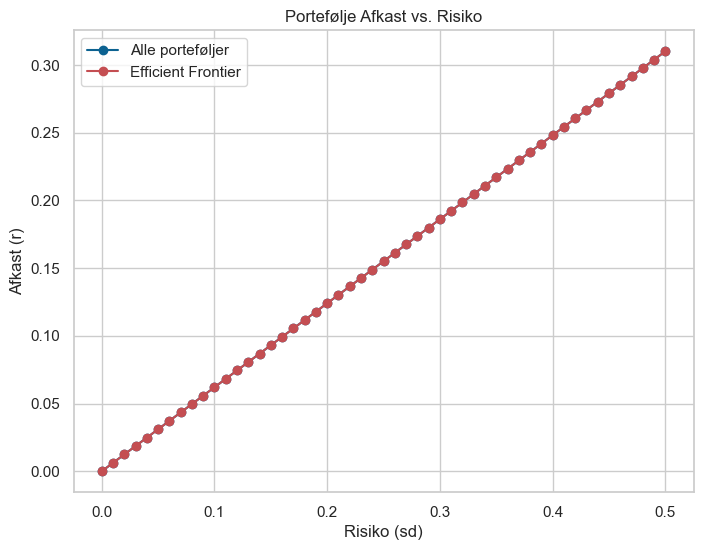

In [109]:
# Lad os antage, at vi vil plotte afkast ("r") mod risiko ("sd")
plt.figure(figsize=(8,6))
plt.plot(factor_ss['sd'], factor_ss['r'], 'o-', label='Alle porteføljer')
plt.xlabel("Risiko (sd)")
plt.ylabel("Afkast (r)")
plt.title("Portefølje Afkast vs. Risiko")
plt.legend()
plt.grid(True)

# Udled den efficient frontier (ikke-dominerede porteføljer)
# Vi sorterer data efter stigende risiko:
df_sorted = factor_ss.sort_values('sd')

# Her antager vi, at en portefølje er effektiv, hvis den giver et højere afkast end alle med lavere risiko
efficient = []
max_r = -float('inf')
for idx, row in df_sorted.iterrows():
    if row['r'] > max_r:
        efficient.append(row)
        max_r = row['r']

efficient_df = pd.DataFrame(efficient)

# Marker de effektive porteføljer i plottet:
plt.plot(efficient_df['sd'], efficient_df['r'], 'ro-', label='Efficient Frontier')
plt.legend()
plt.show()


In [110]:
mv_risky_ef = mv_risky_fun(chars, barra_cov, wealth_0, dates_oos, pf_set['gamma_rel'], u_vec)
mv_risky_ef

,inv,shorting,turnover,r,tc,eom_ret,u
0,9.219179,4.109589,9.272736,0.011682,0.0,2011-01-31,-0.5
1,12.745927,5.872963,10.194211,-0.012991,0.0,2011-02-28,-0.5
2,6.644145,2.822073,9.535282,-0.023628,0.0,2011-03-31,-0.5
3,9.496749,4.248375,7.245291,0.009981,0.0,2011-04-30,-0.5
4,5.300703,2.150352,7.801487,0.016067,0.0,2011-05-31,-0.5
...,...,...,...,...,...,...,...
3595,113.441809,56.220904,84.553837,0.237891,0.0,2022-08-31,2.0
3596,151.703840,75.351920,108.119799,0.561509,0.0,2022-09-30,2.0
3597,37.590202,18.295101,127.443042,0.136774,0.0,2022-10-31,2.0
3598,57.006153,28.003077,38.270962,-0.250700,0.0,2022-11-30,2.0


In [111]:
wealth_0 = Prepare_Data.wealth_func(wealth_end=0, end=settings['split']['test_end'], market=market, risk_free=risk_free)
mv_risky_ef = mv_risky_fun(chars, barra_cov, wealth_0, dates_oos, pf_set['gamma_rel'], u_vec)
# Udregn summary-statistikker for mv_risky_ef
mv_ss = mv_risky_ef.groupby('u').apply(lambda df: pd.Series({
    'n': len(df),
    'inv': df['inv'].mean(),
    'to': df['turnover'].mean(),
    'r': df['r'].mean() * 12,
    'sd': df['r'].std() * np.sqrt(12),
    'sr_gross': (df['r'].mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan,
    'tc': df['tc'].mean() * 12,
    'r_tc': ((df['r'] - df['tc']).mean() * 12),
    'sr': ((df['r'] - df['tc']).mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan,
    'obj': (df['r'].mean() - 0.5 * df['r'].var() * pf_set['gamma_rel'] - df['tc'].mean()) * 12
})).reset_index()

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\1054396638.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [112]:
mv_ss

,u,n,inv,to,r,sd,sr_gross,tc,r_tc,sr,obj
0,-5.000000e-01,144.0,22.944022,27.327764,-0.297573,0.534239,-0.557003,0.0,-0.297573,-0.557003,-1.724632
1,-4.500000e-01,144.0,21.799627,26.572008,-0.275397,0.516622,-0.533072,0.0,-0.275397,-0.533072,-1.609886
2,-4.000000e-01,144.0,20.691853,25.850298,-0.253220,0.499908,-0.506534,0.0,-0.253220,-0.506534,-1.502759
3,-3.500000e-01,144.0,19.645702,25.162612,-0.231044,0.484191,-0.477175,0.0,-0.231044,-0.477175,-1.403251
4,-3.000000e-01,144.0,18.690301,24.511988,-0.208868,0.469573,-0.444804,0.0,-0.208868,-0.444804,-1.311363
5,-2.500000e-01,144.0,17.829966,23.901319,-0.186692,0.456158,-0.409270,0.0,-0.186692,-0.409270,-1.227094
6,-2.000000e-01,144.0,17.043540,23.339963,-0.164516,0.444056,-0.370484,0.0,-0.164516,-0.370484,-1.150444
7,-1.500000e-01,144.0,16.322358,22.831581,-0.142339,0.433376,-0.328443,0.0,-0.142339,-0.328443,-1.081414
8,-1.000000e-01,144.0,15.676091,22.386996,-0.120163,0.424226,-0.283253,0.0,-0.120163,-0.283253,-1.020004
9,-5.000000e-02,144.0,15.128540,22.011588,-0.097987,0.416707,-0.235146,0.0,-0.097987,-0.235146,-0.966213


In [113]:
output_path

'.\\new_data\\'

In [114]:
bms_path = os.path.join(output_path, "bms.csv")

# Læs bms.csv
bms = pd.read_csv(bms_path)

# Konverter eom_ret til datetime
bms["eom_ret"] = pd.to_datetime(bms["eom_ret"])
bms["type"] = "Static-ML"
static_file_path = os.path.join(".", folder_name, "static.pkl")
pfml_file_path = os.path.join(".", folder_name, "pfml_seed_10_new.pkl")
with open(static_file_path, "rb") as f:
    static = pickle.load(f)

with open(pfml_file_path, "rb") as f:
    pfml = pickle.load(f)

In [115]:
def process_cluster_labels(file_path_cluster_labels, file_path_factor_details):
    """
    Behandler cluster labels og faktor detaljer ved at kombinere og transformere data.

    Funktionens opgaver:
    1. Læs cluster labels fra en CSV-fil.
    2. Læs faktor detaljer fra en Excel-fil.
    3. Transformér cluster-navne til små bogstaver og erstat mellemrum og bindestreger med underscores.
    4. Slå cluster labels og faktor detaljer sammen på karakteristika.
    5. Tilføj en ny række for 'rvol_252d' med specifikke værdier.
    6. Returner den opdaterede DataFrame.

    Parametre:
    - file_path_cluster_labels (str): Sti til CSV-filen med cluster labels.
    - file_path_factor_details (str): Sti til Excel-filen med faktor detaljer.

    Krav:
    - openpyxl skal være installeret for at kunne læse Excel-filen.
      Installer med: `pip install openpyxl`


    #Eksempel på brug af funktionen:
    file_path_cluster_labels = "Data/Cluster Labels.csv"
    file_path_factor_details = "Data/Factor Details.xlsx"
    cluster_labels = process_cluster_labels(file_path_cluster_labels, file_path_factor_details)

    Returnerer:
    - pd.DataFrame: En opdateret DataFrame med de transformerede data.
    """
    # Læs data fra CSV og Excel
    cluster_labels = pd.read_csv(file_path_cluster_labels)
    factor_signs = pd.read_excel(file_path_factor_details, engine="openpyxl")

    # Transformer 'cluster' kolonnen
    cluster_labels['cluster'] = cluster_labels['cluster'].str.lower().str.replace(r"\s|-", "_", regex=True)

    # Vælg og transformer relevante kolonner fra Excel-data
    factor_signs = (
        factor_signs[['abr_jkp', 'direction']]
        .rename(columns={'abr_jkp': 'characteristic'})
        .dropna(subset=['characteristic'])
    )
    factor_signs['direction'] = pd.to_numeric(factor_signs['direction'], errors='coerce')

    # Slå de to datasæt sammen
    cluster_labels = pd.merge(cluster_labels, factor_signs, on='characteristic', how='left')

    # Tilføj en ny række for 'rvol_252d'
    new_row = {'characteristic': 'rvol_252d', 'cluster': 'low_risk', 'direction': -1}
    cluster_labels = pd.concat([cluster_labels, pd.DataFrame([new_row])], ignore_index=True)

    return cluster_labels

In [116]:
file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"
cluster_labels = process_cluster_labels(file_path_cluster_labels, file_path_factor_details)

In [206]:
output_path

'.\\new_data\\'

In [117]:
def create_lambda(x, ids):
    return np.diag([x[i] for i in ids])


def pfml_w(data, dates, cov_list, lambda_list, gamma_rel, iter, risk_free, wealth, mu, aims):

    fa_weights = General_Functions.initial_weights_new(data, w_type="vw")
    # Merge med de kolonner, der er nødvendige fra data (f.eks. 'tr_ld1')
    fa_weights = pd.merge(fa_weights, data[['id', 'eom', 'tr_ld1']], on=['id', 'eom'], how='left')
    # Merge med wealth for at få 'mu_ld1'
    fa_weights = pd.merge(fa_weights, wealth[['eom', 'mu_ld1']], on='eom', how='left')

    # --- For hver dato i dates: beregn m og opdater vægtene ---
    for d in dates:
        # d er en streng (f.eks. 'YYYY-MM-DD')
        # Opret datoen som pd.Timestamp for sammenligning
        d_ts = pd.to_datetime(d)
        # Hent ids for observationer i data for denne dato
        ids = data[data['eom'] == d]['id'].unique().astype(str).tolist()
        d_str = d.strftime('%Y-%m-%d')
 #       print("d_str")
 #       print(d_str)
        # Opret sigma og lambda for de givne ids. Her antages, at cov_list og lambda_list benyttes med nøglen d.
        # Vi konverterer nøglen til pd.Timestamp for at matche, hvis nødvendigt.
       # sigma = General_Functions.create_cov(cov_list[pd.to_datetime(d)], ids=ids)
        #sigma = General_Functions.create_cov(cov_list[d.strftime('%Y-%m-%d')], ids=ids)  # rettet her sidste # har virket
        sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        lambda_series = pd.Series(lambda_list[d_str])
        lambda_series.index = lambda_series.index.astype(str)
        lam = create_lambda(lambda_series, ids=ids)
        w = wealth[wealth['eom'] == d]['wealth'].iloc[0]
        rf_val = risk_free[risk_free['eom'] == d]['rf'].iloc[0]
        m =portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
           lambda_mat=lam, iter=iter)

        iden = np.eye(m.shape[0])
        
        w_cur = pd.merge(fa_weights[fa_weights['eom'] == d], aims, on=['id', 'eom'], how='left')
        w_cur['w_opt'] = (m @ w_cur['w_start'].values) + ((iden - m) @ w_cur['w_aim'].values)

        try:
            current_index = dates.get_loc(d)
            next_month = dates[current_index + 1]
            next_month_str = next_month.strftime('%Y-%m-%d')
            next_month = next_month_str
        except IndexError:
            next_month = None

           # Beregn w_opt_ld1 = w_opt * (1 + tr_ld1) / (1 + mu_ld1)
        w_cur['w_opt_ld1'] = w_cur['w_opt'] * (1 + w_cur['tr_ld1']) / (1 + w_cur['mu_ld1'])
        #print(w_cur.dtypes)

        fa_weights = pd.merge(w_cur[['id', 'w_opt', 'w_opt_ld1', 'eom']], 
                              fa_weights, on=['id', 'eom'], how='right')

        mask_current = (fa_weights['eom'] == d) & (fa_weights['w_opt'].notna())
        fa_weights.loc[mask_current, 'w'] = fa_weights.loc[mask_current, 'w_opt']
        #print("fa_weights 2")        
        #print(fa_weights)
        
        # For rækker med eom == next_month, sæt w_start til w_opt_ld1
        if next_month is not None:
            # Lav en kopi af w_cur og opdater 'eom' til next_month
            w_cur_next = w_cur.copy()
            w_cur_next['eom'] = pd.to_datetime(next_month)
            
            # Hvis der skulle være dubletter, kan du evt. fjerne dem
            w_cur_next = w_cur_next.drop_duplicates(subset=['id', 'eom'])
            
            # Merge med fa_weights (her kan du vælge left join, hvis fa_weights skal være basen)
            merged = pd.merge(fa_weights, 
                              w_cur_next[['id', 'w_opt_ld1', 'eom']], 
                              on=['id', 'eom'], 
                              how='left', 
                              suffixes=('', '_next'))
            
            # Tæl antallet af matches pr. (id, eom) – her tæller vi, om vi fandt en match for next_month
            merged['match_count'] = merged.groupby(['id', 'eom'])['w_opt_ld1_next'].transform(lambda x: x.notna().sum())
            
            # Gem original w_start for at kunne se ændringen
            merged['w_start_orig'] = merged['w_start']
            
            # Hvis vi har en match (og altså en værdi i w_opt_ld1_next), opdater w_start
            mask_next = (merged['eom'] == pd.to_datetime(next_month)) & (merged['w_opt_ld1_next'].notna())
            merged.loc[mask_next, 'w_start'] = merged.loc[mask_next, 'w_opt_ld1_next']
            
            # Hvis w_start stadig er NaN for next_month, sæt den til 0
            mask_next_na = (merged['eom'] == pd.to_datetime(next_month)) & (merged['w_start'].isna())
            merged.loc[mask_next_na, 'w_start'] = 0
            
            # Beregn forskellen mellem den opdaterede w_start og den oprindelige værdi
            merged['w_start_diff'] = merged['w_start'] - merged['w_start_orig']
            
            # Fjern hjælpekolonner, hvis de ikke skal bruges
            merged.drop(columns=['w_opt_ld1_next', 'w_start_orig'], inplace=True)
            
            # Hvis du ønsker at se resultatet, kan du til sidst sætte fa_weights til merged
            fa_weights = merged
        
        # Til sidst fjernes de ikke ønskede kolonner
        fa_weights.drop(columns=['w_opt', 'w_opt_ld1'], inplace=True)
        

    
    return fa_weights

#  Feature importance IEF

In [118]:
def pfml_cf_fun(data, cf_cluster, pfml_base, dates, cov_list, scale, orig_feat, gamma_rel, wealth, risk_free, mu, iter, seed):
    """
    Portfolio-ML med kontrafaktuelle inputs.
    
    Parametre:
        data = chars
        cf_cluster (str): Den kontrafaktuelle klynge. Hvis denne ikke er "bm", omarrangeres id'erne.
        pfml_base (dict): Pfml-base, fx indeholder hyperparametre og aim-koefficienter.
        dates = dates (f.eks. out-of-sample datoer)
        cov_list (dict): f.eks. barra
        scale (bool): Skalering med volatilitet.
        orig_feat (list): Oprindelige feature-navne.
        gamma_rel (float): Parameter for risikojustering.
        wealth (float): Formueparameter.
        risk_free (float): Risikofri rente.
        mu (float): Forventet afkast.
        iter (int): Antal iterationer til optimering.
        seed (int): Seed til randomisering.

    Eksempel:
    pf_cf = pfml_cf_fun(data=chars, cf_cluster="bm", pfml_base=pfml, dates= dates_oos, cov_list=barra_cov, 
            scale = settings['pf_ml']['scale'], orig_feat = settings['pf_ml']['orig_feat'], 
            gamma_rel =10, wealth = wealth, risk_free=risk_free , mu = pf_set['mu'], iter =10, seed =10)
    Returnerer:
        pd.DataFrame med den kontrafaktuelle portefølje, inkl. 'w_aim', 'type' ("Portfolio-ML") og 'cluster'.
    """
    # --- Trin 1: Skalering af data (hvis scale er True) ---
    if scale:
        scales_list = []
        for d in dates:
            d_str = d.strftime('%Y-%m-%d')
            sigma = General_Functions.create_cov(barra_cov[d_str])
            if hasattr(sigma, 'values'):
                sigma_vals = sigma.values
                ids_sigma = sigma.index.astype(float)
            else:
                sigma_vals = sigma
                ids_sigma = np.arange(sigma.shape[0])
            diag_vol = np.sqrt(np.diag(sigma_vals))
            df_scales = pd.DataFrame({
                'id': ids_sigma,
                'eom': d_str,
                'vol_scale': diag_vol
            })
            scales_list.append(df_scales)
        scales_df = pd.concat(scales_list, ignore_index=True)
        # Konverter eom til datetime, hvis nødvendigt
        scales_df['eom'] = pd.to_datetime(scales_df['eom'])
        data = pd.merge(data, scales_df, on=['id', 'eom'], how='left')
        data['vol_scale'] = data.groupby('eom')['vol_scale'].transform(lambda x: x.fillna(x.median()))
    
    # --- Trin 2: Sæt seed for randomisering ---
    np.random.seed(seed)
    
    # --- Trin 3: Forbered kontrafaktuelle data ---
    # Forventer at 'features' er en global liste med navne på feature-kolonner.
    cf = data[['id', 'eom', 'vol_scale'] + features].copy()
    
    # --- Trin 4: Hvis cf_cluster ikke er "bm", omarranger id'erne ---
    if cf_cluster != "bm":
        # For hver 'eom', lav en tilfældig permutation af 'id'
        cf['id_shuffle'] = cf.groupby('eom')['id'].transform(lambda x: np.random.permutation(x.values))
        # Vælg relevante karakteristika ud fra cluster_labels
        chars_sub = cluster_labels.loc[
            (cluster_labels['cluster'] == cf_cluster) & (cluster_labels['characteristic'].isin(features)),
            'characteristic'
        ].tolist()
        # Lav en DataFrame med de originale feature-værdier, men med 'id' omdøbt til 'id_shuffle'
        chars_data = cf[['id', 'eom'] + chars_sub].copy().rename(columns={'id': 'id_shuffle'})
        # Fjern de oprindelige feature-kolonner fra cf
        cf = cf.drop(columns=chars_sub)
        # Merge, så de kontrafaktuelle rækker får feature-værdier fra en tilfældigt valgt (shuffled) række
        cf = pd.merge(cf, chars_data, on=['id_shuffle', 'eom'], how='left')
    
    # --- Trin 5: Beregn kontrafaktuel aim-portefølje for hver dato ---
    aim_cf_list = []
    for d in dates:
        # Sørg for at arbejde med data for den aktuelle dato
        d_date = pd.to_datetime(d)
        cf_d = cf[cf['eom'] == d_date].copy()
        d_str = str(d_date.date())
        # Hent hyperparametre og aim-koefficienter for datoen
        best_hps = pfml_base['best_hps_list'][d_str]
        best_g = best_hps['g']
        best_p = best_hps['p']
        aim_coef = best_hps['coef']  # Forventet at være et 1D numpy-array
        best_g_str = str(best_g)
        rff_w = pfml_base['hps'][best_g_str]['rff_w'][:, :int(best_p/2)]
        
        # Hent feature-input for den aktuelle dato
        X = cf_d[features]
        # Anvend random Fourier transformation – her antages rff returnerer en dict med 'X_cos' og 'X_sin'
        rff_x = rff(X, p=best_p, W=rff_w)
        X_cos = rff_x['X_cos']
        X_sin = rff_x['X_sin']
        s = np.hstack([X_cos, X_sin])
        n_features = int(best_p/2)
        col_names = [f"rff{i+1}_cos" for i in range(n_features)] + [f"rff{i+1}_sin" for i in range(n_features)]
        # Brug X.index, da dette svarer til den subset, der faktisk blev transformeret
        s_df = pd.DataFrame(s, columns=col_names, index=X.index)
        
        # Demean hver kolonne
        s_df = s_df - s_df.mean()
        # Tilføj konstant-kolonne med værdien 1
        s_df['constant'] = 1
        # Skaler hver kolonne, så L2-normen bliver 1
        s_df = s_df.apply(lambda x: x * (1/np.sqrt(np.sum(x**2))) if np.sum(x**2) > 0 else x)
        
        # Omdøb/omarranger kolonnerne ifølge pfml_feat_fun
        feat_order = portfolio_choice_functions.pfml_feat_fun(p=best_p, orig_feat=orig_feat)
        s_df = s_df[feat_order]
        
        # Hvis scale er True, juster med inverse volatilitetsskalaer
        if scale:
            vol_scales = cf_d['vol_scale'].values
            inv_vol = np.diag(1/vol_scales)
            s_scaled = inv_vol @ s_df.values
            s_df = pd.DataFrame(s_scaled, columns=s_df.columns, index=s_df.index)
        
        # Beregn aim-vægten: matrixproduktet af s og aim_coef
        w_aim = s_df.values @ aim_coef
        aim_cf_d = pd.DataFrame({
            'id': cf_d['id'].values,
            'eom': cf_d['eom'].values,
            'w_aim': w_aim
        })
        aim_cf_list.append(aim_cf_d)
    aim_cf = pd.concat(aim_cf_list, ignore_index=True)
    
    # --- Trin 6: Beregn den kontrafaktuelle portefølje ---
    data_subset = data[(data['eom'].isin(dates_oos)) & (data['valid'] == True)][['id', 'eom', 'eom_ret', 'me', 'tr_ld1', 'valid']].copy()
    w_cf = pfml_w(data_subset, dates=dates, cov_list=cov_list, lambda_list=lambda_list, gamma_rel=gamma_rel,
                  iter=iter, risk_free=risk_free, wealth=wealth, mu=mu, aims=aim_cf)
    
    # --- Trin 7: Beregn porteføljens tidsserieudvikling ---
    pf_cf = General_Functions.pf_ts_fun(w_cf, data=data, wealth=wealth, gam=gamma_rel)
    pf_cf['type'] = "Portfolio-ML"
    
    # --- Trin 8: Tilføj klyngeinformation og returner resultatet ---
    pf_cf['cluster'] = cf_cluster
    return pf_cf


In [119]:
output_path

'.\\new_data\\'

In [33]:
gamma_rel_index = [1, 2, 3]

In [34]:
gamma_rel_index

[1, 2, 3]

In [ ]:
with open(static_file_path, "rb") as f:
    static = pickle.load(f)

with open(pfml_file_path, "rb") as f:
    pfml = pickle.load(f)

In [120]:
pfml_cf_ief_list = []
gamma_rel_index = [10]
ief_cf_clusters = ["quality", "value", "momentum", "short_term_reversal"]

for gamma_rel in gamma_rel_index:
    # Byg strengen for at læse den rigtige pickle-fil
    # Brug variablen filename, og sørg for korrekt string-notation og indrykning
    with open(pfml_file_path, "rb") as f:
        pfml = pickle.load(f)
    pfml_cf_base_list = []

    for cf_cluster in ief_cf_clusters:
        # Filtrer "chars" så kun de rækker med valid == True medtages
        pf_cf = pfml_cf_fun(
            data=chars[chars['valid'] == True],
            cf_cluster=cf_cluster,
            pfml_base=pfml,
            dates=dates_oos,
            cov_list=barra_cov,
            scale=settings['pf_ml']['scale'],
            orig_feat=settings['pf_ml']['orig_feat'],
            gamma_rel=gamma_rel,
            wealth=wealth,
            risk_free=risk_free,
            mu=pf_set['mu'],
            iter=10,
            seed=settings['seed_no']
        )
        pfml_cf_base_list.append(pf_cf)
    
    # Saml resultaterne for den nuværende gamma_rel
    pfml_cf_base = pd.concat(pfml_cf_base_list, ignore_index=True)
    pfml_cf_base['gamma_rel'] = gamma_rel
    pfml_cf_ief_list.append(pfml_cf_base)

# Kombiner alle resultaterne
pfml_cf_ief = pd.concat(pfml_cf_ief_list, ignore_index=True)
pfml_cf_ief.to_csv(os.path.join(output_path, "pfml_cf_ief.csv"), index=False)

In [121]:
settings['ef']['gamma_rel']

[1, 5, 10, 20, 100]

In [123]:
pfml_cf_ief

,inv,shorting,turnover,r,tc,eom_ret,type,cluster,gamma_rel
0,0.625586,0.159112,0.811452,-0.000701,0.003003,2011-01-31,Portfolio-ML,quality,10
1,0.691319,0.232082,0.252104,0.012836,0.000574,2011-02-28,Portfolio-ML,quality,10
2,0.889757,0.328621,0.337350,0.011061,0.001664,2011-03-31,Portfolio-ML,quality,10
3,0.924029,0.345319,0.174006,0.016477,0.000379,2011-04-30,Portfolio-ML,quality,10
4,1.011868,0.375780,0.228117,0.004221,0.000473,2011-05-31,Portfolio-ML,quality,10
...,...,...,...,...,...,...,...,...,...
571,1.680253,0.784194,0.157063,0.000266,0.000391,2022-08-31,Portfolio-ML,short_term_reversal,10
572,1.707638,0.794742,0.171955,-0.009606,0.000512,2022-09-30,Portfolio-ML,short_term_reversal,10
573,1.701388,0.799432,0.145433,0.006477,0.000382,2022-10-31,Portfolio-ML,short_term_reversal,10
574,1.683283,0.779366,0.165470,0.009696,0.000550,2022-11-30,Portfolio-ML,short_term_reversal,10


In [124]:
output_path

'.\\new_data\\'

In [152]:
file_path = os.path.join(output_path, "pfml_cf_ief.csv")
pfml_cf_ief = pd.read_csv(file_path)

In [ ]:
pfml_cf_base

In [126]:
output_path

'.\\new_data\\'

In [127]:
#file_path = os.path.join(output_path, "pfml_cf_base.csv")
pfml_cf_base.to_csv(os.path.join(output_path, "pfml_cf_base.csv"), index=False)

#  Feature importance base

In [128]:
def tpf_cf_fun(data, cf_cluster, er_models, cluster_labels, wealth, gamma_rel, cov_list, dates, seed):
    np.random.seed(seed)
    
    if cf_cluster != "bm":
        # Fjern kolonner, der starter med "pred_ld"
        cf = data.loc[:, ~data.columns.str.startswith("pred_ld")].copy()
        # Tilføj "id_shuffle" kolonne: for hver gruppe defineret af 'eom' laves en tilfældig permutation af 'id'
        cf['id_shuffle'] = cf.groupby('eom')['id'].transform(lambda x: np.random.permutation(x.values))
        
        # Hent de relevante karakteristika for den givne klynge fra cluster_labels
        chars_sub = cluster_labels.loc[
            (cluster_labels['cluster'] == cf_cluster) & (cluster_labels['characteristic'].isin(features)),
            'characteristic'
        ].tolist()
        
        # Filtrer for kun at bruge de kolonner, der findes i cf
        available_chars = [col for col in chars_sub if col in cf.columns]
        
        # Lav en DataFrame med de originale feature-værdier, men med 'id' omdøbt til 'id_shuffle'
        chars_data = cf[['id', 'eom'] + available_chars].copy().rename(columns={'id': 'id_shuffle'})
        # Fjern de oprindelige feature-kolonner fra cf
        cf = cf.drop(columns=available_chars)
        # Merge cf med chars_data på ['id_shuffle', 'eom']
        cf = pd.merge(cf, chars_data, on=['id_shuffle', 'eom'], how='left')
        
        # Forventede afkast: for hver model i er_models
        for m_sub in er_models.values():
            # Debug-print
            try:
                pred = m_sub['pred']
            except Exception as e:
                pred = None
            try:
                sub_dates = np.unique(pred['eom'])
            except Exception as e:
                sub_dates = np.array([pred])
            
            # Vælg rækker fra cf, hvor 'eom' er i sub_dates, og udtræk kolonnerne angivet i features
            cf_x = cf.loc[cf['eom'].isin(sub_dates), features].to_numpy()
            # Anvend rff-transformation med modelens W og passér p
            rff_x = rff(cf_x, p=m_sub['opt_hps']['p'], W=m_sub['W'])
            # Kombiner cosine- og sine-komponenter og gang med m_sub['opt_hps']['p']^(-0.5)
            cf_new_x = (m_sub['opt_hps']['p'] ** (-0.5)) * np.hstack([rff_x['X_cos'], rff_x['X_sin']])
            # Kalder predict() uden 'newx' og 's' keywords (sklearn Ridge forventer blot X)
            pred_values = m_sub['fit'].predict(cf_new_x)
            pred_values = np.ravel(pred_values)
            cf.loc[cf['eom'].isin(sub_dates), 'pred_ld1'] = pred_values
    else:
        cf = data[data['valid'] == True].copy()
    
    # Implementér TPF på de kontrafaktuelle data.
    op = portfolio_choice_functions.tpf_implement(data=cf, cov_list=cov_list, wealth=wealth, dates=dates, gam=gamma_rel)
    op_pf = op['pf'].copy()
    op_pf['cluster'] = cf_cluster
    return op_pf


In [129]:
cf_clusters = ["bm"] + ief_cf_clusters
tpf_cf_wealth = Prepare_Data.wealth_func(wealth_end=0, end=settings['split']['test_end'], market=market, risk_free=risk_free)
model_file = os.path.join(output_path, "demeaned_model_1.pkl")
with open(model_file, "rb") as f:
    er_models = pickle.load(f)

C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code o

# Fejl her i tc bliver 0. Ved virkelig ikke hvorfor

In [161]:
tpf_cf_base_list = []
for cf_cluster in cf_clusters:
    pf_cf = tpf_cf_fun(
        data = chars[chars['valid'] == True],
        cf_cluster = cf_cluster,
        er_models = er_models,
        dates = dates_oos,
        cluster_labels = cluster_labels,
        cov_list = barra_cov,
        gamma_rel = 100,  # Brug en højere gamma for at gøre TPF mindre ekstrem
        wealth = tpf_cf_wealth,
        seed = settings['seed_no']
    )
    tpf_cf_base_list.append(pf_cf)

tpf_cf_base = pd.concat(tpf_cf_base_list, ignore_index=True)

# Gem som CSV
tpf_cf_base.to_csv(os.path.join(output_path, "tpf_cf_base.csv"), index=False)

In [162]:
tpf_cf_base

,inv,shorting,turnover,r,tc,eom_ret,type,cluster
0,3.346263,1.619517,3.672139,-0.021330,0.0,2011-01-31,Markowitz-ML,bm
1,3.544950,1.636056,3.367643,0.031346,0.0,2011-02-28,Markowitz-ML,bm
2,3.581168,1.803229,3.410119,0.027436,0.0,2011-03-31,Markowitz-ML,bm
3,3.599633,1.726067,3.374020,0.024153,0.0,2011-04-30,Markowitz-ML,bm
4,3.650879,1.888520,3.842604,0.003295,0.0,2011-05-31,Markowitz-ML,bm
...,...,...,...,...,...,...,...,...
715,0.871106,0.441355,0.804187,0.000941,0.0,2022-08-31,Markowitz-ML,short_term_reversal
716,0.841156,0.425268,0.837361,0.004340,0.0,2022-09-30,Markowitz-ML,short_term_reversal
717,0.890963,0.451078,0.787319,-0.002845,0.0,2022-10-31,Markowitz-ML,short_term_reversal
718,0.913867,0.461721,0.853911,-0.004635,0.0,2022-11-30,Markowitz-ML,short_term_reversal


# Feature importance ret

In [163]:
from tqdm import tqdm


In [164]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

def compute_cluster_stats(g, cls):
    try:
        mse = np.mean((g['pred'] - g['ret_pred'])**2)
    except Exception as e:
        print("Fejl i gruppe for eom =", g.name)
        print("Gruppe data (første 5 rækker):")
        print(g.head())
        if 'pred' not in g.columns:
            print("Kolonnen 'pred' findes ikke!")
        else:
            print("NaN i 'pred':", g['pred'].isna().sum())
        raise e
    return pd.Series({'cluster': cls, 'n': g.shape[0], 'mse': mse})

ret_cf_list = []
# Brug output_path som stien til modellerne
get_from_path_model = output_path

# Loop over model-iterationer h = 1 til 1 (kun model_1)
for h in tqdm(range(1, 2), desc="Model iteration"):
    # Læs model (pickle-fil)
    chars = chars[chars['valid'] == True].copy()
    filename = os.path.join(get_from_path_model, f"demeaned_model_{h}.pkl")
    with open(filename, "rb") as f:
        model = pickle.load(f)
    
    # --- Forbered data ---
    # Udtræk returdata: kolonner id, eom og ret_pred (baseret på ret_ld{h})
    pred_y = data_ret[['id', 'eom']].copy()
    pred_y['ret_pred'] = data_ret[f"ret_ld{h}"]
    
    # Merge med chars på id og eom
    ret_cf_data = pd.merge(pred_y, chars, on=['id', 'eom'], how='left')
    # Filtrer ud rækker med manglende ret_pred
    ret_cf_data = ret_cf_data[ret_cf_data['ret_pred'].notna()]
    
    # --- Merger med model-prediktioner ---
    # Udtræk "preds" fra modellen: for hver model i iterationen, udtræk DataFrame med ['id', 'eom', 'pred']
    if isinstance(model, dict):
        preds_list = [m_sub['pred'][['id', 'eom', 'pred']] for m_sub in model.values() if m_sub.get('pred') is not None]
    else:
        preds_list = [m_sub['pred'][['id', 'eom', 'pred']] for m_sub in model if m_sub.get('pred') is not None]
    if preds_list:
        preds = pd.concat(preds_list, ignore_index=True)
        # Merge preds med ret_cf_data på ['id', 'eom']
        ret_cf_data = pd.merge(ret_cf_data, preds, on=['id', 'eom'], how='left')
        ret_cf_data = ret_cf_data[ret_cf_data['ret_pred'].notna()]
    else:
        print("Advarsel: Ingen modelprediktioner fundet for h =", h)
    
    # --- Implementer counterfactual for hver cluster ---
    cluster_results = []
    # Lav en liste: benchmark "bm" plus de sorterede cf_clusters
    cf_clusters_list = ["bm"] + sorted(cf_clusters)
    for cls in tqdm(cf_clusters_list, desc="Counterfactual clusters", leave=False):
        np.random.seed(settings['seed_no'])
        print(f"   {cls}")
        if cls == "bm":
            cf = ret_cf_data.copy()
        else:
            # Fjern kolonnen 'pred', hvis den findes, for at starte med counterfactual-data
            cf = ret_cf_data.copy().drop(columns=['pred'], errors='ignore')
            # Tilføj en "id_shuffle" kolonne: for hver dato (eom) lav en tilfældig permutation af 'id'
            cf['id_shuffle'] = cf.groupby('eom')['id'].transform(lambda x: np.random.permutation(x.values))
            
            # Hent de relevante karakteristika for den aktuelle klynge
            cls_chars = cluster_labels.loc[
                (cluster_labels['cluster'] == cls) & (cluster_labels['characteristic'].isin(features)),
                'characteristic'
            ].tolist()
            # Lav en DataFrame med de originale feature-værdier, men med 'id' omdøbt til 'id_shuffle'
            chars_data = cf[['id', 'eom'] + cls_chars].copy().rename(columns={'id': 'id_shuffle'})
            # Fjern de oprindelige cls_chars-kolonner fra cf
            cf = cf.drop(columns=cls_chars, errors='ignore')
            # Merge cf med chars_data på ['id_shuffle', 'eom']
            cf = pd.merge(cf, chars_data, on=['id_shuffle', 'eom'], how='left')
            
            # Forventede afkast: for hver model i den aktuelle model-iteration
            for m_sub in model.values() if isinstance(model, dict) else model:
                if m_sub.get("pred") is not None:
                    sub_dates = np.unique(m_sub["pred"]['eom'])
                    # Udtræk feature-input til de rækker, hvor eom er blandt sub_dates
                    cf_x = cf.loc[cf['eom'].isin(sub_dates), features].to_numpy()
                    # Anvend rff-transformation med modelens W – passér også parameteren p
                    rff_x = rff(cf_x, p=m_sub["opt_hps"]["p"], W=m_sub["W"])
                    # Beregn de nye inputs: gang med p^(-0.5)
                    cf_new_x = (m_sub["opt_hps"]["p"] ** (-0.5)) * np.hstack([rff_x["X_cos"], rff_x["X_sin"]])
                    # Hvis der er NaN i cf_new_x, fjern de rækker:
                    if np.isnan(cf_new_x).any():
                        mask_nan = ~np.isnan(cf_new_x).any(axis=1)
                        cf_new_x = cf_new_x[mask_nan]
                    # Kald predict() – Ridge-modellen accepterer ikke 'newx' og 's' som keywords
                    pred_vals = m_sub["fit"].predict(cf_new_x)
                    pred_vals = np.ravel(pred_vals)
                    
                    # Debug: Tjek antallet af rækker i masken og antallet af pred_vals
                    mask = cf['eom'].isin(sub_dates)
                    indices = cf.index[mask]
                    print(f"DEBUG: For model, mask count = {len(indices)}, pred_vals count = {len(pred_vals)}")
                    if len(pred_vals) != len(indices):
                        print(f"Mismatch: {len(indices)} rækker, {len(pred_vals)} forudsagte værdier.")
                        n_assign = min(len(pred_vals), len(indices))
                        indices_to_assign = indices[:n_assign]
                        cf.loc[indices_to_assign, 'pred'] = pred_vals[:n_assign]
                    else:
                        cf.loc[indices, 'pred'] = pred_vals
        
        # Beregn statistikker for den aktuelle klynge: for hver dato (eom)
        try:
            res = cf.groupby('eom', group_keys=False).apply(lambda g: compute_cluster_stats(g, cls)).reset_index()
        except Exception as e:
            print(f"Fejl ved behandling af cluster {cls}")
            raise e
        cluster_results.append(res)
    
    # Kombiner resultaterne for denne model-iteration og tilføj kolonnen h = h
    ret_cf_h = pd.concat(cluster_results, ignore_index=True)
    ret_cf_h['h'] = h
    ret_cf_list.append(ret_cf_h)

# Kombiner alle model-iterationers resultater (her vil der kun være én)
ret_cf = pd.concat(ret_cf_list, ignore_index=True)
# Gem til CSV
ret_cf.to_csv(os.path.join(output_path, "ret_cf.csv"), index=False)


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.2. This might lead to breaking code o

   bm


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3007257536.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

nterfactual clusters:  17%|███████████████████▊                                                                                                   | 1/6 [00:00<00:02,  1.96it/s]

   bm


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3007257536.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

nterfactual clusters:  33%|███████████████████████████████████████▋                                                                               | 2/6 [00:00<00:01,  2.04it/s]

   momentum
DEBUG: For model, mask count = 3720, pred_vals count = 3207
Mismatch: 3720 rækker, 3207 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3442
Mismatch: 3720 rækker, 3442 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3500
Mismatch: 3720 rækker, 3500 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3549
Mismatch: 3720 rækker, 3549 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3651
Mismatch: 3720 rækker, 3651 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3692
Mismatch: 3720 rækker, 3692 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3708
Mismatch: 3720 rækker, 3708 forudsagte værdier.
DEBUG: For model, mask count = 3716, pred_vals count = 3716
DEBUG: For model, mask count = 3708, pred_vals count = 3690
Mismatch: 3708 rækker, 3690 forudsagte værdier.
DEBUG: For model, mask count = 3708, pred_vals count = 3684
Mism

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3007257536.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

nterfactual clusters:  50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [00:03<00:04,  1.52s/it]

   quality
DEBUG: For model, mask count = 3720, pred_vals count = 3207
Mismatch: 3720 rækker, 3207 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3442
Mismatch: 3720 rækker, 3442 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3500
Mismatch: 3720 rækker, 3500 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3549
Mismatch: 3720 rækker, 3549 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3651
Mismatch: 3720 rækker, 3651 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3692
Mismatch: 3720 rækker, 3692 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3708
Mismatch: 3720 rækker, 3708 forudsagte værdier.
DEBUG: For model, mask count = 3716, pred_vals count = 3716
DEBUG: For model, mask count = 3708, pred_vals count = 3690
Mismatch: 3708 rækker, 3690 forudsagte værdier.
DEBUG: For model, mask count = 3708, pred_vals count = 3684
Misma

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3007257536.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

nterfactual clusters:  67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [00:06<00:03,  1.97s/it]

   short_term_reversal
DEBUG: For model, mask count = 3720, pred_vals count = 3207
Mismatch: 3720 rækker, 3207 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3442
Mismatch: 3720 rækker, 3442 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3500
Mismatch: 3720 rækker, 3500 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3549
Mismatch: 3720 rækker, 3549 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3651
Mismatch: 3720 rækker, 3651 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3692
Mismatch: 3720 rækker, 3692 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3708
Mismatch: 3720 rækker, 3708 forudsagte værdier.
DEBUG: For model, mask count = 3716, pred_vals count = 3716
DEBUG: For model, mask count = 3708, pred_vals count = 3690
Mismatch: 3708 rækker, 3690 forudsagte værdier.
DEBUG: For model, mask count = 3708, pred_vals count 

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3007257536.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

nterfactual clusters:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [00:09<00:02,  2.25s/it]

   value
DEBUG: For model, mask count = 3720, pred_vals count = 3207
Mismatch: 3720 rækker, 3207 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3442
Mismatch: 3720 rækker, 3442 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3500
Mismatch: 3720 rækker, 3500 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3549
Mismatch: 3720 rækker, 3549 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3651
Mismatch: 3720 rækker, 3651 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3692
Mismatch: 3720 rækker, 3692 forudsagte værdier.
DEBUG: For model, mask count = 3720, pred_vals count = 3708
Mismatch: 3720 rækker, 3708 forudsagte værdier.
DEBUG: For model, mask count = 3716, pred_vals count = 3716
DEBUG: For model, mask count = 3708, pred_vals count = 3690
Mismatch: 3708 rækker, 3690 forudsagte værdier.
DEBUG: For model, mask count = 3708, pred_vals count = 3684
Mismatc

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3007257536.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

Model iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.45s/it]


In [165]:
ret_cf

,eom,cluster,n,mse,h
0,1952-12-31,bm,46,NaN,1
1,1953-01-31,bm,47,NaN,1
2,1953-02-28,bm,47,NaN,1
3,1953-03-31,bm,47,NaN,1
4,1953-04-30,bm,47,NaN,1
...,...,...,...,...,...
5035,2022-07-31,value,310,0.004230,1
5036,2022-08-31,value,310,0.013184,1
5037,2022-09-30,value,310,0.020784,1
5038,2022-10-31,value,310,0.010622,1


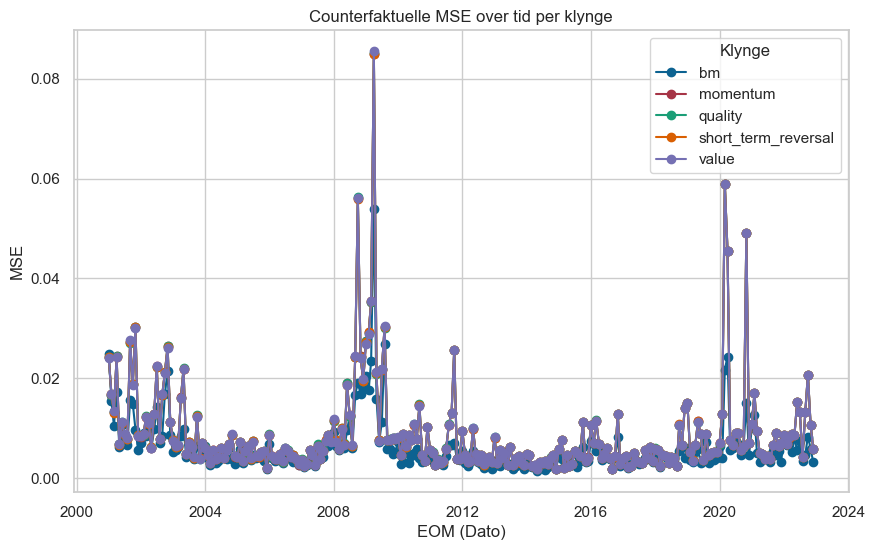

In [137]:
ret_cf['eom'] = pd.to_datetime(ret_cf['eom'])

# Pivotér dataen, så vi får en DataFrame med eom som index og en kolonne for hver klynge
mse_pivot = ret_cf.pivot_table(index='eom', columns='cluster', values='mse')

plt.figure(figsize=(10, 6))
for cluster in mse_pivot.columns:
    plt.plot(mse_pivot.index, mse_pivot[cluster], marker='o', label=cluster)

plt.xlabel("EOM (Dato)")
plt.ylabel("MSE")
plt.title("Counterfaktuelle MSE over tid per klynge")
plt.legend(title="Klynge")
plt.grid(True)
plt.show()

# Economic intuition
ligner fejl her et sted

In [138]:
ew = portfolio_choice_functions.ew_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set=pf_set)
mkt = portfolio_choice_functions.mkt_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)
rw = portfolio_choice_functions.rw_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)
mv = portfolio_choice_functions.mv_implement(data=chars, cov_list=barra_cov ,wealth=wealth, dates=dates_oos, pf_set= pf_set)
factor_ml = portfolio_choice_functions.factor_ml_implement(data = chars, wealth = wealth, dates= dates_oos, n_pfs=settings["factor_ml"]["n_pfs"]
, gam=pf_set['gamma_rel'])
tpf = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

with open(static_file_path, "rb") as f:
    static = pickle.load(f)

with open(pfml_file_path, "rb") as f:
    pfml = pickle.load(f)

In [140]:


pf_order = [
    # "Portfolio-ML",  # denne er kommenteret ud som i R-koden
    "Static-ML",
    "Static-ML*",
    "Portfolio-ML",
    "Markowitz-ML",
    "Factor-ML",
    "Rank-ML",
    "Minimum Variance",
    "1/N",
    "Market"
]



In [141]:
import datetime

def expected_risk_fun(ws, dates, cov_list):
    """
    Beregn forventet porteføljevarians for hver portefølje (metode) og dato.

    Parametre:
      - ws (pd.DataFrame): DataFrame med porteføljeoplysninger med kolonnerne 
           'id' (asset id), 'type' (metode, fx "Portfolio-ML"), 'eom' (dato) og 'w' (aktivets vægt).
      - dates (list): Liste af datoer (pd.Timestamp, datetime eller str) for udvælgelse.
      - cov_list (dict): Dictionary med kovariansmatricer. Nøglerne skal være datoer i formatet 'YYYY-MM-DD'.
    
    Returnerer:
      pd.DataFrame med kolonnerne 'type', 'pf_var' og 'eom'.
    """
    # Sørg for, at ws er sorteret ensartet efter type, eom og id
    ws_sorted = ws.sort_values(by=['type', 'eom', 'id'])
    types = ws_sorted['type'].unique()
    
    # Lav en ordbog, der grupperer ws_sorted efter eom.
    # Nøglerne konverteres til str i formatet 'YYYY-MM-DD'
    w_list = {}
    for eom_val, group in ws_sorted.groupby('eom'):
        if isinstance(eom_val, (pd.Timestamp, datetime.datetime)):
            key = eom_val.strftime('%Y-%m-%d')
        else:
            key = str(eom_val)
        w_list[key] = group.copy()
    
    results = []
    for d in dates:
        # Konverter dato d til string i formatet 'YYYY-MM-DD'
        if isinstance(d, (pd.Timestamp, datetime.datetime)):
            d_str = d.strftime('%Y-%m-%d')
        else:
            d_str = str(d)
        w_sub = w_list.get(d_str)
        if w_sub is None:
            continue  # Ingen data for denne dato
        # Sorter w_sub efter id for konsistens
        w_sub = w_sub.sort_values(by='id')
        # Få unikke asset ids (som strenge)
        ids = w_sub['id'].unique().astype(str)
        # Hent sigma for denne dato; nøglen i cov_list skal matche d_str
        sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        for t in types:
            # Vælg de rækker, hvor 'type' == t, og sorter efter id for at sikre, at rækkefølgen stemmer overens
            subset = w_sub[w_sub['type'] == t].sort_values(by='id')
            # Antag, at der for hver dato og type er én observation pr. aktiv,
            # så kolonnen 'w' udgør et vektor med vægte
            w_vec = subset['w'].values.astype(float)
            # Beregn porteføljevariansen: w^T * sigma * w
            pf_var = np.dot(np.dot(w_vec.T, sigma), w_vec)
            results.append({'type': t, 'pf_var': float(pf_var), 'eom': d_str})
    return pd.DataFrame(results)

In [142]:
base_path = output_path
# Læs CSV-filen med pandas
bm_pfs = pd.read_csv(os.path.join(base_path, "bms.csv"))

# Konverter eom_ret til dato
bm_pfs['eom_ret'] = pd.to_datetime(bm_pfs['eom_ret'])

# Erstat "Rank-Weighted" med "Rank-ML" i kolonnen type
bm_pfs.loc[bm_pfs['type'] == 'Rank-Weighted', 'type'] = 'Rank-ML'

pfs = bm_pfs

In [143]:
print(pfs.isnull().sum())


inv         0
shorting    0
turnover    0
r           0
tc          0
eom_ret     0
type        0
dtype: int64


In [144]:
pfml_w

<function __main__.pfml_w(data, dates, cov_list, lambda_list, gamma_rel, iter, risk_free, wealth, mu, aims)>

In [145]:
import seaborn as sns
main_types = ["Markowitz-ML", "Factor-ML", "Market", "Rank-ML", "Minimum Variance", "Static-ML", "Static-ML*"]
# 1. Kombiner portefølje-dataframes med tildelt type
pfml_w = pfml['w'].copy()
pfml_w['type'] = "Portfolio-ML"

tpf_w = tpf['w'].copy()
tpf_w['type'] = "Markowitz-ML"

static_w = static['w'].copy()
if 'pred_ld1' in static_w.columns:
    static_w = static_w.drop(columns=['pred_ld1'])
static_w['type'] = "Static-ML*"

factor_ml_w = factor_ml['w'].copy()
factor_ml_w['type'] = "Factor-ML"

ws = pd.concat([pfml_w, tpf_w, static_w, factor_ml_w], ignore_index=True)

# Sørg for, at type-kolonnen har den ønskede rækkefølge
ws['type'] = pd.Categorical(ws['type'], categories=pf_order, ordered=True)

# 2. Beregn forventet porteføljerisiko (forvent, at funktionen returnerer en DataFrame med fx pf_var og eom)
pf_vars = expected_risk_fun(ws, dates_oos, barra_cov)

# 3. Forbered pfs-data. I R beregnes eom som eom_ret + 1 måned - 1 dag.
pfs2 = pfs.copy()
pfs2['eom'] = pd.to_datetime(pfs2['eom_ret'])
pfs2 = pfs2[['type', 'eom', 'inv', 'turnover']]

# Sørg for, at eom-kolonnen i både pf_vars og pfs2 er datetime64[ns]
pf_vars['eom'] = pd.to_datetime(pf_vars['eom'])
pfs2['eom'] = pd.to_datetime(pfs2['eom'])
# 4. Join pf_vars med pfs2 på 'type' og 'eom'
comp_stats = pf_vars.merge(pfs2, on=['type','eom'], how='left')


# 4. Join pf_vars med pfs2 på 'type' og 'eom'
comp_stats = pf_vars.merge(pfs2, on=['type','eom'], how='left')

# 5. Filtrer for de hovedtyper, vi vil medtage
comp_stats = comp_stats[comp_stats['type'].isin(main_types)]

# 6. Udregn eks-ante volatilitet: e_sd = sqrt(pf_var * 252)
comp_stats['e_sd'] = np.sqrt(comp_stats['pf_var'] * 252)
comp_stats = comp_stats.drop(columns=['pf_var'])

In [146]:
pfs2

,type,eom,inv,turnover
0,Markowitz-ML,2011-01-31,33.462627,33.483340
1,Markowitz-ML,2011-02-28,35.449499,33.676433
2,Markowitz-ML,2011-03-31,35.811680,34.101189
3,Markowitz-ML,2011-04-30,35.996332,33.740200
4,Markowitz-ML,2011-05-31,36.508787,38.426036
...,...,...,...,...
1147,Static-ML*,2022-08-31,2.499463,0.611423
1148,Static-ML*,2022-09-30,2.817038,0.927989
1149,Static-ML*,2022-10-31,2.687497,1.722441
1150,Static-ML*,2022-11-30,2.713148,0.401101


In [147]:
pf_vars

,type,pf_var,eom
0,Static-ML*,0.000498,2010-12-31
1,Portfolio-ML,0.004587,2010-12-31
2,Markowitz-ML,0.023013,2010-12-31
3,Factor-ML,0.002330,2010-12-31
4,Static-ML*,0.000867,2011-01-31
...,...,...,...
571,Factor-ML,0.005127,2022-10-31
572,Static-ML*,0.000472,2022-11-30
573,Portfolio-ML,0.010762,2022-11-30
574,Markowitz-ML,0.016095,2022-11-30


In [148]:
comp_stats

,type,eom,inv,turnover,e_sd
0,Static-ML*,2010-12-31,NaN,NaN,0.354180
2,Markowitz-ML,2010-12-31,NaN,NaN,2.408177
3,Factor-ML,2010-12-31,NaN,NaN,0.766301
4,Static-ML*,2011-01-31,0.651105,0.618754,0.467325
6,Markowitz-ML,2011-01-31,33.462627,33.483340,2.783725
...,...,...,...,...,...
570,Markowitz-ML,2022-10-31,18.362609,29.653517,2.562077
571,Factor-ML,2022-10-31,2.000000,1.584121,1.136704
572,Static-ML*,2022-11-30,2.713148,0.401101,0.344767
574,Markowitz-ML,2022-11-30,13.593207,9.795053,2.013930


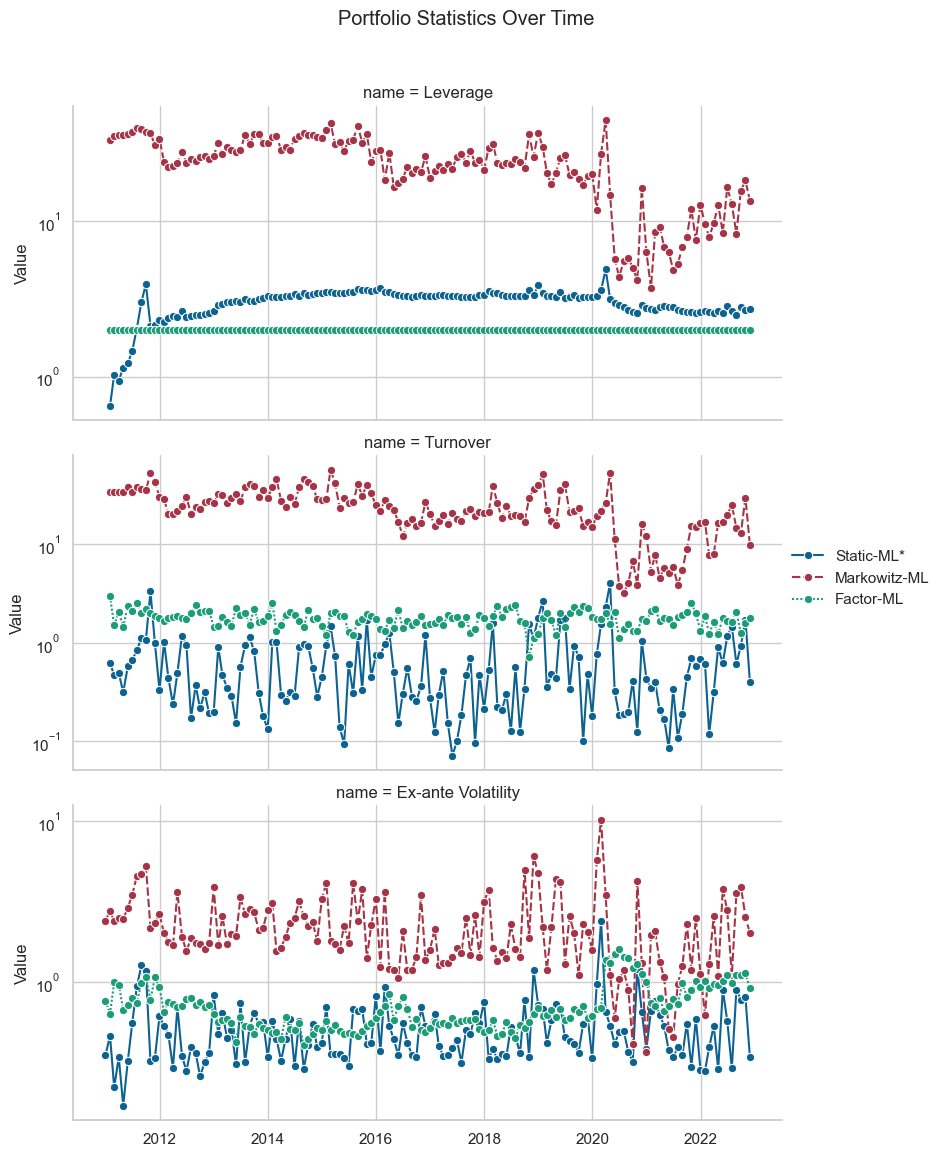

In [149]:


# 7. "Pivot longer" – omform dataene fra bred til lang form (så alle mål bliver i én kolonne)
comp_stats_melt = comp_stats.melt(id_vars=['type', 'eom'], var_name='name', value_name='value')

# 8. Omdøb variable: 'e_sd' -> 'Ex-ante Volatility', 'turnover' -> 'Turnover', 'inv' -> 'Leverage'
name_map = {
    'e_sd': 'Ex-ante Volatility',
    'turnover': 'Turnover',
    'inv': 'Leverage'
}
comp_stats_melt['name'] = comp_stats_melt['name'].map(name_map)

# 9. Plot – vi bruger seaborn FacetGrid til at lave et facet wrap med 1 kolonne
g = sns.FacetGrid(comp_stats_melt, col="name", col_wrap=1, sharey=False, height=4, aspect=2)
g.map_dataframe(sns.lineplot, x="eom", y="value", hue="type", style="type", marker="o")
g.set(yscale="log")
g.set_axis_labels("", "Value")
g.add_legend(title="")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Portfolio Statistics Over Time")
plt.show()

# Feature importance fejl et sted

In [166]:
tpf_cf_base = pd.read_csv(os.path.join(output_path, "tpf_cf_base.csv"))
pfml_cf_base = pd.read_csv(os.path.join(output_path, "pfml_cf_base.csv"))
ret_cf = pd.read_csv(os.path.join(output_path, "ret_cf.csv"))
pfml_cf_ief = pd.read_csv(os.path.join(output_path, "pfml_cf_ief.csv"))

In [158]:
tpf_cf_base

,inv,shorting,turnover,r,tc,eom_ret,type,cluster
0,3.346263,1.619517,3.672139,-0.021330,0.0,2011-01-31,Markowitz-ML,bm
1,3.544950,1.636056,3.367643,0.031346,0.0,2011-02-28,Markowitz-ML,bm
2,3.581168,1.803229,3.410119,0.027436,0.0,2011-03-31,Markowitz-ML,bm
3,3.599633,1.726067,3.374020,0.024153,0.0,2011-04-30,Markowitz-ML,bm
4,3.650879,1.888520,3.842604,0.003295,0.0,2011-05-31,Markowitz-ML,bm
...,...,...,...,...,...,...,...,...
715,0.871106,0.441355,0.804187,0.000941,0.0,2022-08-31,Markowitz-ML,short_term_reversal
716,0.841156,0.425268,0.837361,0.004340,0.0,2022-09-30,Markowitz-ML,short_term_reversal
717,0.890963,0.451078,0.787319,-0.002845,0.0,2022-10-31,Markowitz-ML,short_term_reversal
718,0.913867,0.461721,0.853911,-0.004635,0.0,2022-11-30,Markowitz-ML,short_term_reversal


In [167]:
def cf_obj_func(df, gamma_rel):
    # Beregn cf_obj for en gruppe df:
    return (df['r'].mean() - 0.5 * df['r'].var() * gamma_rel - df['tc'].mean()) * 12

# Gruppér efter type og cluster og beregn cf_obj
pfml_cf_ss = (
    pfml_cf_base
    .groupby(['type', 'cluster'])
    .apply(lambda g: pd.Series({'cf_obj': cf_obj_func(g, pf_set['gamma_rel'])}))
    .reset_index()
)

# For hver 'type' skal vi finde baseline (dvs. cf_obj for cluster=="bm")
baseline_pfml = pfml_cf_ss[pfml_cf_ss['cluster'] == "bm"].set_index('type')['cf_obj'].to_dict()
# Udregn fi: baseline - cf_obj
pfml_cf_ss['fi'] = pfml_cf_ss.apply(lambda row: baseline_pfml.get(row['type'], np.nan) - row['cf_obj'], axis=1)
# Vælg kun kolonnerne type, cluster og fi
pfml_cf_ss = pfml_cf_ss[['type', 'cluster', 'fi']]

C:\Users\andre\AppData\Local\Temp\ipykernel_3572\638751100.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [168]:
def cf_obj_func(df, gamma_rel):
    return (df['r'].mean() - 0.5 * df['r'].var() * gamma_rel - df['tc'].mean()) * 12

tpf_cf_ss = (
    tpf_cf_base
    .groupby(['type', 'cluster'])
    .apply(lambda g: pd.Series({'cf_obj': cf_obj_func(g, pf_set['gamma_rel'])}))
    .reset_index()
)

baseline_tpf = tpf_cf_ss[tpf_cf_ss['cluster'] == "bm"].set_index('type')['cf_obj'].to_dict()
tpf_cf_ss['fi'] = tpf_cf_ss.apply(lambda row: baseline_tpf.get(row['type'], np.nan) - row['cf_obj'], axis=1)
tpf_cf_ss = tpf_cf_ss[['type', 'cluster', 'fi']]


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\438041683.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [169]:
print("pfml_cf_base columns:", pfml_cf_base.columns.tolist())

pfml_cf_base columns: ['inv', 'shorting', 'turnover', 'r', 'tc', 'eom_ret', 'type', 'cluster', 'gamma_rel']


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\344987517.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\andre\AppData\Local\Temp\ipykernel_3572\344987517.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\andre\AppData\Local\Temp\ipykernel_3572\344987517.py:65: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plo

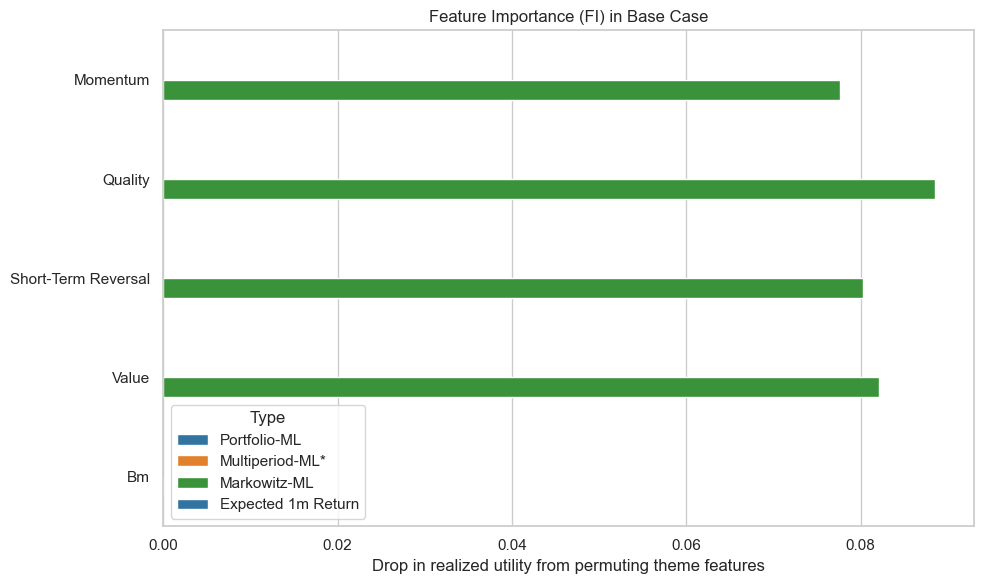

In [170]:
# Hvis kolonnen med afkast hedder noget andet (fx 'return'), så ret nedenstående:
returns_col = 'r'  # Ændr evt. til det rigtige kolonnenavn
tc_col = 'tc'      # Ændr evt. til det rigtige kolonnenavn
colours_theme = ["#1f77b4", "#ff7f0e", "#2ca02c"]
palette=[colours_theme[0], colours_theme[1], colours_theme[2]]

# Hvis kolonnen med afkast hedder noget andet (fx 'return'), så ret nedenstående:
returns_col = 'r'  # Ændr evt. til det rigtige kolonnenavn
tc_col = 'tc'      # Ændr evt. til det rigtige kolonnenavn
colours_theme = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Beregn FI for pfml_cf_base:
def compute_cf_obj(df, gamma_rel):
    # Tjek om de nødvendige kolonner findes:
    if returns_col not in df.columns or tc_col not in df.columns:
        raise KeyError(f"DataFrame mangler kolonnen '{returns_col}' eller '{tc_col}'.")
    mean_r = df[returns_col].mean()
    var_r = df[returns_col].var()
    mean_tc = df[tc_col].mean()
    return (mean_r - 0.5 * var_r * gamma_rel - mean_tc) * 12

pfml_cf_ss = (
    pfml_cf_base
    .groupby(['type', 'cluster'], group_keys=False)
    .apply(lambda g: pd.Series({'cf_obj': compute_cf_obj(g, pf_set['gamma_rel'])}))
    .reset_index()
)

baseline_pfml = pfml_cf_ss[pfml_cf_ss['cluster'] == "bm"].set_index('type')['cf_obj'].to_dict()
pfml_cf_ss['fi'] = pfml_cf_ss.apply(lambda row: baseline_pfml.get(row['type'], np.nan) - row['cf_obj'], axis=1)
pfml_cf_ss = pfml_cf_ss[['type', 'cluster', 'fi']]

# Beregn FI for tpf_cf_base med samme fremgangsmåde
tpf_cf_ss = (
    tpf_cf_base
    .groupby(['type', 'cluster'], group_keys=False)
    .apply(lambda g: pd.Series({'cf_obj': compute_cf_obj(g, pf_set['gamma_rel'])}))
    .reset_index()
)

baseline_tpf = tpf_cf_ss[tpf_cf_ss['cluster'] == "bm"].set_index('type')['cf_obj'].to_dict()
tpf_cf_ss['fi'] = tpf_cf_ss.apply(lambda row: baseline_tpf.get(row['type'], np.nan) - row['cf_obj'], axis=1)
tpf_cf_ss = tpf_cf_ss[['type', 'cluster', 'fi']]

# Saml de to sæt – her kombinerer vi dem til ét DataFrame:
fi_df = pd.concat([pfml_cf_ss, tpf_cf_ss], ignore_index=True)

# Tilføj wealth-kolonne: for pfml_cf_ss sættes wealth til 1e10, for tpf_cf_ss sættes wealth til 0
fi_df['wealth'] = np.where(fi_df['type'] == "Portfolio-ML", 1e10, 0)

# Opdater cluster-navne: erstat "_" med " ", "short term" med "short-term", og konverter til Title Case
fi_df['cluster'] = fi_df['cluster'].str.replace("_", " ", regex=False)
fi_df['cluster'] = fi_df['cluster'].str.replace("short term", "short-term", case=False, regex=False)
fi_df['cluster'] = fi_df['cluster'].str.title()

# Sæt type-ordningen (brug fx de samme niveauer som i R)
type_order = ["Portfolio-ML", "Multiperiod-ML*", "Markowitz-ML", "Expected 1m Return"]
fi_df['type'] = pd.Categorical(fi_df['type'], categories=type_order, ordered=True)

# Filtrer for de hovedtyper, vi vil medtage (udeluk "Expected 1m Return")
fi_df = fi_df[fi_df['type'] != "Expected 1m Return"]

# Plot – eksempel med seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x='fi', y='cluster', hue='type', dodge=True,
            palette=[colours_theme[0], colours_theme[1], colours_theme[2]])
plt.xlabel("Drop in realized utility from permuting theme features")
plt.ylabel("")
plt.title("Feature Importance (FI) in Base Case")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


In [171]:
print(fi_df['type'].unique())


['Portfolio-ML', 'Markowitz-ML']
Categories (4, object): ['Portfolio-ML' < 'Multiperiod-ML*' < 'Markowitz-ML' < 'Expected 1m Return']


Der mangler mere her men find fejl her først

#  Implementable efficient frontier
fejl i tc

In [172]:
vol_range = np.arange(0, 0.5 + 0.01, 0.01)

In [173]:
# Factor-ML

factor_base = portfolio_choice_functions.factor_ml_implement(data=chars, dates=dates_oos, n_pfs=settings['factor_ml']['n_pfs'], wealth=wealth, gam=pf_set['gamma_rel'])

factor_base_vol = factor_base['pf']['r'].std() * np.sqrt(12)
factor_ef_list = []
for vol_target in tqdm(vol_range, desc="Volatility Levels"):
    scale = vol_target / factor_base_vol  # Skalering for at ramme target-volatiliteten
    w_copy = factor_base['w'].copy()
    # Forvent, at w_copy har kolonnerne 'w' og 'w_start'
    w_copy['w'] = w_copy['w'] * scale
    w_copy['w_start'] = w_copy['w_start'] * scale
    # Kald pf_ts_fun – vi antager, at den accepterer en parameter w_data med de vægte, der skal anvendes
    pf_ts = portfolio_choice_functions.pf_ts_fun(data=chars, wealth=wealth, gam=pf_set['gamma_rel'],weights=w_copy )
    pf_ts['vol_target'] = vol_target
    factor_ef_list.append(pf_ts)


factor_ef = pd.concat(factor_ef_list, ignore_index=True)
factor_ef['type'] = "Factor-ML"

def summarize_group(df, gamma_rel):
    n = len(df)
    inv = df['inv'].mean()
    to = df['turnover'].mean()
    r_mean = df['r'].mean() * 12
    r_sd = df['r'].std() * np.sqrt(12)
    sr_gross = (df['r'].mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan
    tc = df['tc'].mean() * 12
    r_tc = (df['r'] - df['tc']).mean() * 12
    sr = ((df['r'] - df['tc']).mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan
    obj = (df['r'].mean() - 0.5 * df['r'].var() * gamma_rel - df['tc'].mean()) * 12
    return pd.Series({'n': n, 'inv': inv, 'to': to, 'r': r_mean, 'sd': r_sd,
                      'sr_gross': sr_gross, 'tc': tc, 'r_tc': r_tc, 'sr': sr, 'obj': obj})

factor_ss = factor_ef.groupby('vol_target').apply(lambda g: summarize_group(g, pf_set['gamma_rel'])).reset_index()

baseline_obj = factor_ss.loc[factor_ss['vol_target'] == 0, 'obj']
if not baseline_obj.empty:
    baseline_val = baseline_obj.values[0]
    factor_ss['fi'] = baseline_val - factor_ss['obj']
else:
    factor_ss['fi'] = np.nan


Volatility Levels: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.25it/s]
C:\Users\andre\AppData\Local\Temp\ipykernel_3572\2086090568.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [174]:
# Markowitz-ML
tpf_base = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set['gamma_rel'])
# tpf_base forventes at være en dictionary med nøglerne 'pf' og 'w'
# tpf_base['pf'] skal være en DataFrame med kolonnen 'r'
tpf_base_vol = tpf_base['pf']['r'].std() * np.sqrt(12)  # Årlig standardafvigelse

# 2. For hvert vol_target i vol_range skal vi skalere vægtene og beregne porteføljestatistikker
factor_list = []
for vol_target in tqdm(vol_range, desc="Volatility Levels"):
    scale = vol_target / tpf_base_vol  # Skalering for at ramme samme mål-volatilitet
    # Kopiér tpf_base['w'] – antages at være en DataFrame med kolonnerne 'w' og 'w_start'
    w_scaled = tpf_base['w'].copy()
    w_scaled['w'] = w_scaled['w'] * scale
    w_scaled['w_start'] = w_scaled['w_start'] * scale
    # Kald pf_ts_fun for at beregne porteføljestatistikker med de skalerede vægte
    # Vi antager, at pf_ts_fun accepterer parameteren w_data (vægtdata) sammen med data, wealth og gam
    pf_ts = portfolio_choice_functions.pf_ts_fun(data=chars, wealth=wealth, gam=pf_set['gamma_rel'], weights=w_scaled)
    # Tilføj vol_target-kolonnen
    pf_ts['vol_target'] = vol_target
    factor_list.append(pf_ts)

# Kombiner resultaterne for alle vol_target
tpf_ef = pd.concat(factor_list, ignore_index=True)
tpf_ef['type'] = "Markowitz-ML"

# 3. Beregn gruppestatistik pr. vol_target (svarende til tpf_ss)
def summarize_group(df, gamma_rel):
    n = df.shape[0]
    inv = df['inv'].mean()
    turnover = df['turnover'].mean()
    r_mean = df['r'].mean() * 12
    sd = df['r'].std() * np.sqrt(12)
    sr_gross = (df['r'].mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan
    tc = df['tc'].mean() * 12
    r_tc = df.apply(lambda row: (row['r'] - row['tc']), axis=1).mean() * 12
    sr = (df.apply(lambda row: (row['r'] - row['tc']), axis=1).mean() / df['r'].std() * np.sqrt(12)) if df['r'].std() != 0 else np.nan
    obj = (df['r'].mean() - 0.5 * df['r'].var() * gamma_rel - df['tc'].mean()) * 12
    return pd.Series({'n': n, 'inv': inv, 'to': turnover, 'r': r_mean, 'sd': sd, 
                      'sr_gross': sr_gross, 'tc': tc, 'r_tc': r_tc, 'sr': sr, 'obj': obj})

tpf_ss = tpf_ef.groupby('vol_target').apply(lambda g: summarize_group(g, pf_set['gamma_rel'])).reset_index()

# tpf_ss er nu en DataFrame med statistikker for hver vol_target
# Hvis du vil beregne FI, skal du definere en baseline. I R koden ser det ud til, at FI beregnes
# som: baseline (for cluster "bm") minus cf_obj.
# Hvis tpf_ef ikke har en 'cluster'-kolonne (eller hvis den alle er samme type),
# kan du vælge en baseline – fx ved vol_target = 0.
baseline_obj = tpf_ss.loc[tpf_ss['vol_target'] == 0, 'obj']
if not baseline_obj.empty:
    baseline_val = baseline_obj.values[0]
    tpf_ss['fi'] = baseline_val - tpf_ss['obj']
else:
    tpf_ss['fi'] = np.nan


Volatility Levels: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.59it/s]
C:\Users\andre\AppData\Local\Temp\ipykernel_3572\532760861.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [175]:
def mv_risky_fun(data, cov_list, wealth, dates, gam, u_vec):
    # Filtrér data: behold kun de rækker, der er gyldige og hvor 'eom' er blandt de ønskede datoer.
    # Udvælg kun de relevante kolonner.
    data_rel = data.loc[(data["valid"]) & (data["eom"].isin(dates)), ["id", "eom", "me", "tr_ld1", "pred_ld1"]].copy()
    # Sortér efter "id" og "eom" for konsistens
    data_rel = data_rel.sort_values(by=["id", "eom"])
    
    # Split data_rel i en dictionary, hvor hver nøgle er en dato (som str, fx "2010-12-31")
    data_split = {}
    for eom_val, group in data_rel.groupby("eom"):
        # Konverter eom til string, hvis det er et datetime-objekt:
        if hasattr(eom_val, "strftime"):
            key = eom_val.strftime('%Y-%m-%d')
        else:
            key = str(eom_val)
        data_split[key] = group.copy()
    
    mv_opt_all = []  # Liste til at samle optimale weights per dato og u
    
    # Loop over datoerne i 'dates'
    for d in dates:
        # Konverter d til string med formatet 'YYYY-MM-DD'
        if hasattr(d, "strftime"):
            d_str = d.strftime('%Y-%m-%d')
        else:
            d_str = str(d)
        if d_str not in data_split:
            print(f"Advarsel: Ingen data for dato {d_str}")
            continue
        data_sub = data_split[d_str]
        ids = data_sub["id"]
        
        # Hent kovariansmatrixen for datoen via create_cov. Sørg for, at ids (som str) overholder den forventede rækkefølge.
        sigma = General_Functions.create_cov(cov_list[d_str], ids=ids.astype(str))
        # Inverter sigma
        sigma_inv = np.linalg.inv(sigma)
        
        # Udtræk forventede returneringsværdier fra 'pred_ld1'
        er = data_sub["pred_ld1"].values
        # Opret en vektor med 1'ere (samme længde som er)
        ones = np.ones_like(er)
        
        # Beregn parameterne a, b, c og d (som i R-koden)
        a = er.T @ sigma_inv @ er
        b = sigma_inv @ er
        c = sigma_inv @ ones
        d_aux = a * c.sum() - (b.sum())**2
        
        # For hvert u i u_vec beregnes de optimale weights
        for u in u_vec:
            # Den optimale vægtberegning (svarer til R: ((sum(c)*u - sum(b))/d)* (sigma_inv %*% er) + ((a - sum(b)*u)/d)*(sigma_inv %*% ones))
            weights = ((c.sum() * u - b.sum()) / d_aux) * (sigma_inv @ er) + \
                      ((a - b.sum() * u) / d_aux) * (sigma_inv @ ones)
            # Lav en DataFrame for de aktuelle weights
            weights_df = pd.DataFrame({
                "id": data_sub["id"].values,
                "eom": d,
                "u": u * 12,  # Konverter u til årlig basis
                "w": weights
            })
            mv_opt_all.append(weights_df)
    
    # Saml alle vægtdata til én DataFrame
    mv_opt_all = pd.concat(mv_opt_all, ignore_index=True)
    
    # Byg porteføljer: For hver unik u-værdi, anvendes funktionen w_fun og pf_ts_fun til at beregne porteføljen.
    results = []
    for u_sel in mv_opt_all["u"].unique():
        # Vælg de vægte, der svarer til u_sel
        w = mv_opt_all[mv_opt_all["u"] == u_sel].copy()
        # Vi antager, at w_fun beregner porteføljens vægte, givet data_rel, datoer og wealth.
        weights = portfolio_choice_functions.w_fun(data_rel, dates, w, wealth)
        # Herefter anvendes pf_ts_fun til at beregne porteføljens tidsserieudvikling.
        portfolio = portfolio_choice_functions.pf_ts_fun(weights, data, wealth, gam)
        portfolio["u"] = u_sel
        results.append(portfolio)
    
    return pd.concat(results, ignore_index=True)


In [176]:
# Mean-variance efficient frontier of risky assets ---------------------------------------------
u_vec = np.concatenate([np.arange(-0.5, 0.5+0.05, 0.05), np.array([0.6, 0.75, 1, 2])]) / 12

# 2. Beregn wealth_0 med wealth_func
wealth_0 = Prepare_Data.wealth_func(wealth_end=0, end=settings['split']['test_end'], market=market, risk_free=risk_free)

# 3. Udled den mean-variance efficient frontier for risky assets
# mv_risky_fun skal returnere en DataFrame med en kolonne "u" og fx "inv", "turnover", "r" og "tc"
mv_risky_ef = mv_risky_fun(data=chars, cov_list=barra_cov, wealth=wealth_0, dates=dates_oos, gam=pf_set['gamma_rel'], u_vec=u_vec)

# 4. Gruppér mv_risky_ef efter u og beregn de ønskede statistikker
def summarize_mv(group, gamma_rel):
    n = group.shape[0]
    inv = group['inv'].mean()
    turnover = group['turnover'].mean()
    r_mean = group['r'].mean() * 12
    sd = group['r'].std() * np.sqrt(12)
    sr_gross = (group['r'].mean() / group['r'].std() * np.sqrt(12)) if group['r'].std() != 0 else np.nan
    tc = group['tc'].mean() * 12
    # Beregn mean af (r - tc) pr. observation
    r_tc = group.apply(lambda row: row['r'] - row['tc'], axis=1).mean() * 12
    sr = (group.apply(lambda row: row['r'] - row['tc'], axis=1).mean() / group['r'].std() * np.sqrt(12)) if group['r'].std() != 0 else np.nan
    obj = (group['r'].mean() - 0.5 * group['r'].var() * gamma_rel - group['tc'].mean()) * 12
    return pd.Series({'n': n, 'inv': inv, 'to': turnover, 'r': r_mean, 'sd': sd,
                      'sr_gross': sr_gross, 'tc': tc, 'r_tc': r_tc, 'sr': sr, 'obj': obj})

mv_ss = mv_risky_ef.groupby('u').apply(lambda g: summarize_mv(g, pf_set['gamma_rel'])).reset_index()


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\3701596222.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


# Get IEF portfolios

In [177]:
bms_path = os.path.join(output_path, "bms.csv")

# Læs bms.csv
bms = pd.read_csv(bms_path)

# Konverter eom_ret til datetime
bms["eom_ret"] = pd.to_datetime(bms["eom_ret"])
bms["type"] = "Static-ML"
with open(static_file_path, "rb") as f:
    static = pickle.load(f)

with open(pfml_file_path, "rb") as f:
    pfml = pickle.load(f)

In [178]:
static["hps"]

,inv,shorting,turnover,r,tc,eom_ret,hp_no,k,g,u,cum_mean_r2,cum_mean_r,cum_var,cum_obj,rank
0,0.456829,0.061737,0.675360,-0.009189,0.002376,2001-01-31,0,1.0,0.0,0.25,0.000084,-0.009189,0.000000,-0.011565,25.0
1,0.327716,0.216029,0.459731,0.011567,0.001388,2001-02-28,0,1.0,0.0,0.25,0.000109,0.001189,0.000108,-0.000963,22.0
2,0.561138,0.473885,0.367111,0.025856,0.000853,2001-03-31,0,1.0,0.0,0.25,0.000296,0.009411,0.000207,0.007348,22.0
3,0.584850,0.081620,0.840079,0.036066,0.003948,2001-04-30,0,1.0,0.0,0.25,0.000547,0.016075,0.000288,0.013180,20.0
4,0.621371,0.165400,0.244294,0.007122,0.000332,2001-05-31,0,1.0,0.0,0.25,0.000448,0.014284,0.000244,0.011658,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,1.788354,1.158758,2.271851,0.021256,0.050000,2022-08-31,26,0.2,2.0,1.00,0.025560,0.074421,0.020021,-0.079565,25.0
7124,4.033531,3.545794,2.953147,0.209710,0.125742,2022-09-30,26,0.2,2.0,1.00,0.025630,0.074939,0.020014,-0.079321,25.0
7125,3.001096,0.173946,6.089382,0.256787,0.447204,2022-10-31,26,0.2,2.0,1.00,0.025784,0.075633,0.020064,-0.080128,25.0
7126,3.185148,0.379231,1.373624,0.121993,0.021289,2022-11-30,26,0.2,2.0,1.00,0.025743,0.075809,0.019996,-0.079821,25.0


In [196]:
# Hardcode værdier (da alle filer har samme wealth og gamma)
w_val = 1e10   # eksempel: 1e10
g_val = 3      # eksempel: 3

# 1. Læs bms.csv
bms_file = os.path.join(output_path, "bms.csv")
df_bms = pd.read_csv(bms_file)
df_bms["eom_ret"] = pd.to_datetime(df_bms["eom_ret"])

df_static_pf = static["pf"]
df_static_pf["eom_ret"] = pd.to_datetime(df_static_pf["eom_ret"])

df_pfml_pf = pfml["pf"]
df_pfml_pf["eom_ret"] = pd.to_datetime(df_pfml_pf["eom_ret"])

df_static_hps = static["hps"]
df_static_hps["eom_ret"] = pd.to_datetime(df_static_hps["eom_ret"])

In [197]:
# Konverter eom_ret i static_pf til dato (uden tid)
static_pf_eom = pd.to_datetime(df_static_pf["eom_ret"]).dt.date
mask = (df_static_hps["eom_ret"].dt.date.isin(static_pf_eom)) & \
       (df_static_hps["k"] == 1) & (df_static_hps["g"] == 0) & (df_static_hps["u"] == 1)
df_static_hps_filtered = df_static_hps.loc[mask, ["eom_ret", "inv", "shorting", "turnover", "r", "tc"]].copy()
df_static_hps_filtered["eom_ret"] = pd.to_datetime(df_static_hps_filtered["eom_ret"]).dt.date
df_static_hps_filtered["type"] = "Static-ML"

# 5. Kombiner alle porteføljedata (svarer til rbind i R)
df_combined = pd.concat([df_bms, df_static_pf, df_pfml_pf, df_static_hps_filtered],
                        ignore_index=True, sort=False)

# Tilføj wealth_end og gamma_rel
df_combined["wealth_end"] = w_val
df_combined["gamma_rel"] = g_val
df_combined["eom_ret"] = df_combined["eom_ret"].astype(str)


In [198]:
df_combined

,inv,shorting,turnover,r,tc,eom_ret,type,wealth_end,gamma_rel
0,33.462627,16.195173,33.483340,-0.213304,29.596402,2011-01-31 00:00:00,Markowitz-ML,1.000000e+10,3
1,35.449499,16.360564,33.676433,0.313456,21.257477,2011-02-28 00:00:00,Markowitz-ML,1.000000e+10,3
2,35.811680,18.032289,34.101189,0.274355,29.177682,2011-03-31 00:00:00,Markowitz-ML,1.000000e+10,3
3,35.996332,17.260672,33.740200,0.241527,24.120977,2011-04-30 00:00:00,Markowitz-ML,1.000000e+10,3
4,36.508787,18.885198,38.426036,0.032947,31.953754,2011-05-31 00:00:00,Markowitz-ML,1.000000e+10,3
...,...,...,...,...,...,...,...,...,...
1579,7.699526,3.947986,1.197786,-0.003452,0.009776,2022-08-31,Static-ML,1.000000e+10,3
1580,8.208969,5.122204,1.865759,0.183626,0.030449,2022-09-30,Static-ML,1.000000e+10,3
1581,7.891596,3.237999,3.457882,0.128465,0.090068,2022-10-31,Static-ML,1.000000e+10,3
1582,7.942793,3.118980,0.809406,0.118121,0.007711,2022-11-30,Static-ML,1.000000e+10,3


In [199]:
def safe_date_format(x):
    try:
        # Forsøg at konvertere til datetime med automatisk formatgenkendelse
        dt = pd.to_datetime(x, infer_datetime_format=True, errors='raise')
        return dt.strftime("%Y-%m-%d")
    except Exception:
        # Hvis der opstår en fejl (fx fordi x er NaN eller i et uventet format), så returneres x som streng
        return str(x)

df_combined["eom_ret"] = df_combined["eom_ret"].apply(safe_date_format)


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\1706550917.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [200]:
df_combined

,inv,shorting,turnover,r,tc,eom_ret,type,wealth_end,gamma_rel
0,33.462627,16.195173,33.483340,-0.213304,29.596402,2011-01-31,Markowitz-ML,1.000000e+10,3
1,35.449499,16.360564,33.676433,0.313456,21.257477,2011-02-28,Markowitz-ML,1.000000e+10,3
2,35.811680,18.032289,34.101189,0.274355,29.177682,2011-03-31,Markowitz-ML,1.000000e+10,3
3,35.996332,17.260672,33.740200,0.241527,24.120977,2011-04-30,Markowitz-ML,1.000000e+10,3
4,36.508787,18.885198,38.426036,0.032947,31.953754,2011-05-31,Markowitz-ML,1.000000e+10,3
...,...,...,...,...,...,...,...,...,...
1579,7.699526,3.947986,1.197786,-0.003452,0.009776,2022-08-31,Static-ML,1.000000e+10,3
1580,8.208969,5.122204,1.865759,0.183626,0.030449,2022-09-30,Static-ML,1.000000e+10,3
1581,7.891596,3.237999,3.457882,0.128465,0.090068,2022-10-31,Static-ML,1.000000e+10,3
1582,7.942793,3.118980,0.809406,0.118121,0.007711,2022-11-30,Static-ML,1.000000e+10,3


In [202]:
# Find dubletter baseret på wealth_end, gamma_rel, type og eom_ret
duplicate_mask = df_combined.duplicated(subset=["wealth_end", "gamma_rel", "type", "eom_ret"], keep=False)
duplicates = df_combined.loc[duplicate_mask]

print("Følgende dubletter blev fundet:")
print(duplicates)


Følgende dubletter blev fundet:
           inv  shorting  turnover         r        tc     eom_ret  \
1008  0.651105  0.092097  0.618754  0.001498  0.001712  2011-01-31   
1009  1.026054  0.195293  0.470223  0.022830  0.001150  2011-02-28   
1010  0.945186  0.337876  0.494990  0.014153  0.001225  2011-03-31   
1011  1.144492  0.353729  0.314216  0.032381  0.000514  2011-04-30   
1012  1.217325  0.598111  0.575309  0.018766  0.001527  2011-05-31   
...        ...       ...       ...       ...       ...         ...   
1291  2.499463  1.305545  0.611423  0.003735  0.002502  2022-08-31   
1292  2.817038  1.914241  0.927989  0.085236  0.007632  2022-09-30   
1293  2.687497  0.993258  1.722441  0.062004  0.022358  2022-10-31   
1294  2.713148  0.930988  0.401101  0.043808  0.001916  2022-11-30   
1295  2.670990  1.404433  0.991023  0.007834  0.008385  2022-12-31   

            type    wealth_end  gamma_rel  
1008  Static-ML*  1.000000e+10          3  
1009  Static-ML*  1.000000e+10         

In [201]:


# 6. Kontroller for dubletter: For hver kombination af wealth_end, gamma_rel, type og eom_ret skal der være præcis én række.
group_counts = df_combined.groupby(["wealth_end", "gamma_rel", "type", "eom_ret"]).size().reset_index(name="N")
if (group_counts["N"] != 1).any():
    raise ValueError("Der er dubletter i de kombinerede data!")
else:
    print("Ingen dubletter fundet.")

print("IEF portfolios loaded successfully, shape:", df_combined.shape)


ValueError: Der er dubletter i de kombinerede data!

In [208]:
output_path

'.\\new_data\\'

In [207]:
# skab ef_all

In [209]:
# --- Parametre og stier ---
pf_set = {"wealth": 1e10, "gamma_rel": 3}  # fast wealth, evt. senere varierende
pkl_path = '.\\much_more_data\\'  # mappen med dine pkl-filer
# Få en liste af alle .pkl-filer i mappen
pkl_files = [f for f in os.listdir(pkl_path) if f.endswith('.pkl')]

In [210]:
pkl_files

['pfml_seed_10_NEW_WEALTH1e10_GAMMA1.pkl',
 'pfml_seed_10_NEW_WEALTH1e10_GAMMA10.pkl',
 'static_WEALTH1e10_GAMMA1.pkl',
 'static_WEALTH1e10_GAMMA10.pkl',
 'static_WEALTH1e10_GAMMA100.pkl',
 'static_WEALTH1e10_GAMMA20.pkl',
 'static_WEALTH1e10_GAMMA5.pkl']

In [214]:
results = []

for fname in pkl_files:
    # Ekstraher wealth og gamma fra filnavnet
    # Eksempel: "20250329-2203_WEALTH1e10_GAMMA10_SIZEperc_low50_high100_min50_INDTRUE.pkl"
    wealth_match = re.search(r"(?<=WEALTH)([0-9eE\+]+)", fname)
    gamma_match = re.search(r"(?<=GAMMA)(\d+)", fname)
    if wealth_match:
        # Fjern evt. '+' for nem konvertering
        w_str = wealth_match.group(1).replace("+", "")
        wealth_val = float(w_str)
    else:
        wealth_val = np.nan  # eller sæt en standardværdi
    if gamma_match:
        gamma_val = float(gamma_match.group(1))
    else:
        gamma_val = np.nan

    # Indlæs pickle-filen
    file_path = os.path.join(pkl_path, fname)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # --- Indlæs de enkelte dele ---
    # Forvent, at data indeholder:
    #   "bms": et DataFrame med kolonnen "eom_ret"
    #   "static_ml": en dict med "pf" og "hps"
    #   "portfolio_ml": en dict med "pf"
    # BMS-data
    if "bms" in data:
        bms_df = data["bms"].copy()
        bms_df["eom_ret"] = pd.to_datetime(bms_df["eom_ret"]).dt.date
    else:
        bms_df = pd.DataFrame()
    
    # Static ML: både pf og hps
    if "static_ml" in data:
        static_pf = data["static_ml"].get("pf", pd.DataFrame()).copy()
        static_hps = data["static_ml"].get("hps", pd.DataFrame()).copy()
        # Sørg for, at datoerne i static_pf er rigtige
        if not static_pf.empty:
            static_pf["eom_ret"] = pd.to_datetime(static_pf["eom_ret"]).dt.date
            static_pf_dates = static_pf["eom_ret"].unique()
        else:
            static_pf_dates = []
        if not static_hps.empty:
            static_hps["eom_ret"] = pd.to_datetime(static_hps["eom_ret"]).dt.date
            # Filtrer hps: behold rækker hvor eom_ret er med i static_pf, og hvor k==1, g==0, u==1
            static_hps_filtered = static_hps[
                static_hps["eom_ret"].isin(static_pf_dates) &
                (static_hps["k"] == 1) &
                (static_hps["g"] == 0) &
                (static_hps["u"] == 1)
            ].copy()
            # Tilføj en kolonne "type" med værdien "Static-ML"
            static_hps_filtered["type"] = "Static-ML"
        else:
            static_hps_filtered = pd.DataFrame()
    else:
        static_pf = pd.DataFrame()
        static_hps_filtered = pd.DataFrame()

    # Portfolio ML
    if "portfolio_ml" in data:
        portfolio_pf = data["portfolio_ml"].get("pf", pd.DataFrame()).copy()
        # Sørg for, at eom_ret er konverteret
        if not portfolio_pf.empty:
            portfolio_pf["eom_ret"] = pd.to_datetime(portfolio_pf["eom_ret"]).dt.date
    else:
        portfolio_pf = pd.DataFrame()

    # --- Kombinér data ---
    # Her antages, at alle de indlæste DataFrames har samme kolonne-struktur,
    # evt. med kolonner som: inv, shorting, turnover, r, tc, eom_ret og type (nogle mangler vi til at sætte nedenfor).
    combined_df = pd.concat([bms_df, static_pf, portfolio_pf, static_hps_filtered], ignore_index=True)
    
    # Tilføj wealth_end og gamma_rel fra filnavnet (parsed)
    combined_df["wealth_end"] = wealth_val
    combined_df["gamma_rel"] = gamma_val
    
    results.append(combined_df)

In [268]:
# --- Parametre og stier ---
pf_set = {"wealth": 1e10, "gamma_rel": 3}  # fast wealth, evt. senere varierende
pkl_path = '.\\much_more_data\\'  # mappen med dine pkl-filer
# Få en liste af alle .pkl-filer i mappen
pkl_files = [f for f in os.listdir(pkl_path) if f.endswith('.pkl')]

results = []

for fname in pkl_files:
    # Ekstraher wealth og gamma fra filnavnet
    # Fx: "20250329-2203_WEALTH1e10_GAMMA10_SIZEperc_low50_high100_min50_INDTRUE.pkl"
    wealth_match = re.search(r"(?<=WEALTH)([0-9eE\+]+)", fname)
    gamma_match = re.search(r"(?<=GAMMA)(\d+)", fname)
    if wealth_match:
        w_str = wealth_match.group(1).replace("+", "")
        wealth_val = float(w_str)
    else:
        wealth_val = np.nan
    if gamma_match:
        gamma_val = float(gamma_match.group(1))
    else:
        gamma_val = np.nan

    file_path = os.path.join(pkl_path, fname)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # Vælg hvordan data skal hentes afhængigt af filens type:
    # Hvis filnavnet indeholder "pfml", antag at det er en pfml-fil
    # Hvis det indeholder "static", antag at det er en static-fil.
    
    if "pfml" in fname.lower():
        # For pfml-filer: Vi bruger nøglen "pf" som portefølje og evt. hps hvis nødvendigt.
        pf_df = data.get("pf", pd.DataFrame()).copy()
        if not pf_df.empty:
            pf_df["eom_ret"] = pd.to_datetime(pf_df["eom_ret"]).dt.date
        # Sæt type til "Portfolio-ML"
        pf_df["type"] = "Portfolio-ML"
        combined_df = pf_df.copy()

    elif "static" in fname.lower():
        # For static-filer: Vi henter både "pf" og "hps"
        static_pf = data.get("pf", pd.DataFrame()).copy()
        static_hps = data.get("hps", pd.DataFrame()).copy()

        if not static_pf.empty:
            static_pf["eom_ret"] = pd.to_datetime(static_pf["eom_ret"]).dt.date
            static_pf_dates = static_pf["eom_ret"].unique()
        else:
            static_pf_dates = []
        # For static_hps, hvis der er data:
        if not static_hps.empty:
            static_hps["eom_ret"] = pd.to_datetime(static_hps["eom_ret"]).dt.date
            # Filtrer static_hps, så vi kun beholder rækker, hvor datoen er i static_pf,
            # og hvor k == 1, g == 0 og u == 1.
            static_hps_filtered = static_hps[
                static_hps["eom_ret"].isin(static_pf_dates) &
                (static_hps["k"] == 1) &
                (static_hps["g"] == 0) &
                (static_hps["u"] == 1)
            ].copy()
            static_hps_filtered["type"] = "Static-ML"
        else:
            static_hps_filtered = pd.DataFrame()
        
        # Kombiner static_pf og static_hps_filtered
        combined_df = pd.concat([static_pf, static_hps_filtered], ignore_index=True)
    else:
        # Hvis filnavnet ikke identificerer typen, så spring videre eller sæt combined_df til tom DataFrame.
        combined_df = pd.DataFrame()

    # Tilføj wealth_end og gamma_rel for alle rækker
    if not combined_df.empty:
        combined_df["wealth_end"] = wealth_val
        combined_df["gamma_rel"] = gamma_val
        results.append(combined_df)

# Sammensæt alle data
ief_pfs = pd.concat(results, ignore_index=True)

# Tjek for dubletter (baseret på wealth_end, gamma_rel, type og eom_ret)
group_counts = ief_pfs.groupby(["wealth_end", "gamma_rel", "type", "eom_ret"]).size().reset_index(name="N")
if (group_counts["N"] != 1).any():
    raise ValueError("Der er dubletter i de kombinerede data!")
else:
    print("Ingen dubletter fundet.")

print("Samlet DataFrame har form: ", ief_pfs.shape)

Ingen dubletter fundet.
Samlet DataFrame har form:  (1728, 18)


In [271]:
# Saml alle porteføljedata
ief_pfs = pd.concat(results, ignore_index=True)
nan_counts = ief_pfs.isna().sum()
print(nan_counts)


inv               0
shorting          0
turnover          0
r                 0
tc                0
eom_ret           0
type              0
wealth_end        0
gamma_rel         0
hp_no          1008
k              1008
g              1008
u              1008
cum_mean_r2    1008
cum_mean_r     1008
cum_var        1008
cum_obj        1008
rank           1008
dtype: int64


In [270]:
ief_pfs

,inv,shorting,turnover,r,tc,eom_ret,type,wealth_end,gamma_rel,hp_no,k,g,u,cum_mean_r2,cum_mean_r,cum_var,cum_obj,rank
0,0.899555,0.000457,0.173892,0.019516,0.000133,2011-01-31,Portfolio-ML,1.000000e+10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.870174,0.000775,0.127178,0.030953,0.000092,2011-02-28,Portfolio-ML,1.000000e+10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.868407,0.003168,0.098995,0.006608,0.000061,2011-03-31,Portfolio-ML,1.000000e+10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.893629,0.011748,0.095261,0.026909,0.000062,2011-04-30,Portfolio-ML,1.000000e+10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.922269,0.017311,0.077061,-0.007892,0.000048,2011-05-31,Portfolio-ML,1.000000e+10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,14.786707,7.518051,2.375335,-0.009373,0.029808,2022-08-31,Static-ML,1.000000e+10,5.0,6.0,1.0,0.0,1.0,0.049006,0.107484,0.037453,-0.001634,18.0
1724,15.251573,9.329424,3.133206,0.283552,0.065531,2022-09-30,Static-ML,1.000000e+10,5.0,6.0,1.0,0.0,1.0,0.049126,0.108158,0.037428,-0.001151,18.0
1725,15.603113,6.506512,6.035050,0.315999,0.203708,2022-10-31,Static-ML,1.000000e+10,5.0,6.0,1.0,0.0,1.0,0.049320,0.108951,0.037449,-0.001075,18.0
1726,15.668837,6.296830,1.083682,0.157434,0.010211,2022-11-30,Static-ML,1.000000e+10,5.0,6.0,1.0,0.0,1.0,0.049226,0.109136,0.037316,-0.000866,18.0


In [252]:

# --- Beregn summary-statistikker (ief_ss) ---
def summarize(group):
    inv = group["inv"].mean() if "inv" in group.columns else np.nan
    to = group["turnover"].mean() if "turnover" in group.columns else np.nan
    r_val = group["r"].mean() * 12 if "r" in group.columns else np.nan
    sd_val = group["r"].std() * np.sqrt(12) if "r" in group.columns else np.nan
    sr_gross = (group["r"].mean() / group["r"].std() * np.sqrt(12)) if group["r"].std() != 0 else np.nan
    tc_val = group["tc"].mean() * 12 if "tc" in group.columns else np.nan
    r_tc_val = (group["r"].mean() - group["tc"].mean()) * 12 if ("r" in group.columns and "tc" in group.columns) else np.nan
    sr_val = ((group["r"].mean() - group["tc"].mean()) / group["r"].std() * np.sqrt(12)) if group["r"].std() != 0 else np.nan
    # gamma_rel antages at være konstant i gruppen, så vi tager den første værdi
    gamma_val = group["gamma_rel"].iloc[0] if "gamma_rel" in group.columns else np.nan
    obj_val = (group["r"].mean() - 0.5 * group["r"].var() * gamma_val - group["tc"].mean()) * 12 if ("r" in group.columns and "tc" in group.columns) else np.nan
    return pd.Series({
        "inv": inv,
        "to": to,
        "r": r_val,
        "sd": sd_val,
        "sr_gross": sr_gross,
        "tc": tc_val,
        "r_tc": r_tc_val,
        "sr": sr_val,
        "obj": obj_val
    })

ief_ss = ief_pfs.groupby(["type", "wealth_end", "gamma_rel"]).apply(summarize).reset_index()

# Filtrér så vi kun beholder porteføljer af typen "Portfolio-ML"
ef_ss = ief_ss[ief_ss["type"] == "Portfolio-ML"]

# --- Byg inputs til IEF (ef_all_ss) ---
# For at samle inputs til IEF kombineres:
# 1. IEF-summary for typerne: Portfolio-ML, Static-ML* og Static-ML.
# 2. factor_ss, hvor vi sætter gamma_rel til NaN, type = "Factor-ML" og wealth_end til pf_set["wealth"].
# 3. tpf_ss, hvor vi sætter gamma_rel til NaN, type = "Markowitz-ML" og wealth_end til pf_set["wealth"].
# Forudsæt, at factor_ss og tpf_ss allerede er defineret som DataFrames.

ef_all_ss = pd.concat([
    ief_ss[ief_ss["type"].isin(["Portfolio-ML", "Static-ML*", "Static-ML"])],
    factor_ss.assign(gamma_rel=np.nan, type="Factor-ML", wealth_end=pf_set["wealth"]),
    tpf_ss.assign(gamma_rel=np.nan, type="Markowitz-ML", wealth_end=pf_set["wealth"])
], ignore_index=True, sort=False)

print("Kombineret input (ef_all_ss) har shape:", ef_all_ss.shape)
ef_all_ss.loc[ef_all_ss["type"] == "Markowitz-ML", "gamma_rel"] = 10


Kombineret input (ef_all_ss) har shape: (114, 15)


C:\Users\andre\AppData\Local\Temp\ipykernel_3572\497498065.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [253]:
ef_all_ss

,type,wealth_end,gamma_rel,inv,to,r,sd,sr_gross,tc,r_tc,sr,obj,vol_target,n,fi
0,Portfolio-ML,1.000000e+10,1.0,1.873305,0.065899,0.152023,0.228891,0.664171,0.000647,0.151375,0.661344,0.125180,NaN,NaN,NaN
1,Portfolio-ML,1.000000e+10,10.0,0.521252,0.052083,0.027194,0.035036,0.776179,0.001859,0.025335,0.723130,0.019198,NaN,NaN,NaN
2,Static-ML,1.000000e+10,1.0,41.852736,3.304865,2.979025,1.445205,2.061317,1.078102,1.900923,1.315331,0.856614,NaN,NaN,NaN
3,Static-ML,1.000000e+10,5.0,17.042943,2.109250,1.199130,0.665538,1.801745,0.463898,0.735232,1.104718,-0.372120,NaN,NaN,NaN
4,Static-ML,1.000000e+10,10.0,10.351563,1.580099,0.754063,0.440445,1.712049,0.267762,0.486301,1.104114,-0.483656,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Markowitz-ML,1.000000e+10,10.0,11.761283,11.909163,0.687617,0.460000,1.494820,70.121616,-69.433999,-150.943475,-70.491999,0.46,144.0,70.491999
110,Markowitz-ML,1.000000e+10,10.0,12.016963,12.168058,0.702565,0.470000,1.494820,73.203521,-72.500955,-154.257351,-73.605455,0.47,144.0,73.605455
111,Markowitz-ML,1.000000e+10,10.0,12.272643,12.426953,0.717514,0.480000,1.494820,76.351703,-75.634189,-157.571227,-76.786189,0.48,144.0,76.786189
112,Markowitz-ML,1.000000e+10,10.0,12.528323,12.685848,0.732462,0.490000,1.494820,79.566163,-78.833701,-160.885103,-80.034201,0.49,144.0,80.034201


In [204]:
# mangler før efficient rand

In [228]:
pf_set["gamma_rel"]

3

In [254]:
print("Forskellige wealth_end:", ef_all_ss["wealth_end"].unique())
print("Forskellige gamma_rel:", ef_all_ss["gamma_rel"].unique())


Forskellige wealth_end: [1.e+10]
Forskellige gamma_rel: [  1.  10.   5.  20. 100.  nan]


In [255]:
points = ef_all_ss[
    (
        (ef_all_ss["type"].isin(["Portfolio-ML"])) &
        (ef_all_ss["wealth_end"] == pf_set["wealth"]) &
        (ef_all_ss["gamma_rel"] == 10)
    ) |
    (
        (ef_all_ss["type"].isin(["Static-ML*"])) &
        (ef_all_ss["wealth_end"] == pf_set["wealth"]) &
        (ef_all_ss["gamma_rel"] == 10)
    ) |
    (
        (ef_all_ss["type"].isin(["Static-ML"])) &
        (ef_all_ss["wealth_end"] == pf_set["wealth"]) &
        (ef_all_ss["gamma_rel"] == 10)
    )
].copy()

In [256]:
points

,type,wealth_end,gamma_rel,inv,to,r,sd,sr_gross,tc,r_tc,sr,obj,vol_target,n,fi
1,Portfolio-ML,1.000000e+10,10.0,0.521252,0.052083,0.027194,0.035036,0.776179,0.001859,0.025335,0.723130,0.019198,NaN,NaN,NaN
4,Static-ML,1.000000e+10,10.0,10.351563,1.580099,0.754063,0.440445,1.712049,0.267762,0.486301,1.104114,-0.483656,NaN,NaN,NaN
9,Static-ML*,1.000000e+10,10.0,2.390794,0.782209,0.361853,0.211714,1.709160,0.066151,0.295701,1.396703,0.071588,NaN,NaN,NaN


In [257]:

# 2. Udled indifference curves for hver række i points
# For hver række hentes u_target (fra kolonnen 'obj') og sd_target (fra 'sd').
# Derefter laves en række punkter med sd-værdier i intervallet [0,0.4] med interval 0.01,
# og for hvert v udregnes r_tc = u_target + (pf_set["gamma_rel"]/2) * v^2.
indiff_list = []

# Vi laver en for-loop over hver række i points (ligesom i R: 1:nrow(points))
for idx, row in points.iterrows():
    u_target = row["obj"]
    sd_target = row["sd"]   # sd_target bruges ikke direkte her, men findes i originalkoden
    # Vi definerer et interval fra 0 til 0.4 med 0.01-trin
    for v in np.arange(0, 0.4 + 0.01, 0.01):
        r_tc = u_target + (pf_set["gamma_rel"] / 2) * (v ** 2)
        indiff_list.append({"sd": v, "r_tc": r_tc, "u": u_target})

# Saml alle beregnede punkter til en DataFrame
indifference_curves = pd.DataFrame(indiff_list)

# 3. Figure 1A data udtræk
# tpf_slope: Vælg rækken med type "Markowitz-ML" og hent den anden værdi fra kolonnen "sr_gross".
# Bemærk: Python-indeksering starter ved 0, så .iloc[1] svarer til den 2. observation.
tpf_slope = ef_all_ss[ef_all_ss["type"] == "Markowitz-ML"]["sr_gross"].iloc[1]

# static_raw: Filtrer for rækker med type "Static-ML" og de samme wealth_end og gamma_rel som i pf_set
static_raw = ef_all_ss[
    (ef_all_ss["type"] == "Static-ML") &
    (ef_all_ss["wealth_end"] == pf_set["wealth"]) &
    (ef_all_ss["gamma_rel"] == pf_set["gamma_rel"])
].copy()

# Plot-indstillinger
ef_y_low = -0.2
tpf_col = 10            # Antager at dette f.eks. kan bruges til at bestemme en farve (f.eks. en indeksværdi)
ef_xmax = 0.35
plot_txt_size = 2.5
sta_1l_x = 0.265
sta_1l_y = static_raw["r_tc"]

# Udskriv resultatet (kan evt. plottes med matplotlib)
print("Indifference curves:")
print(indifference_curves.head())
print("\nTPF slope (2. observation for Markowitz-ML):", tpf_slope)
print("\nStatic-ML portefølje:")
print(static_raw.head())


Indifference curves:
     sd      r_tc         u
0  0.00  0.019198  0.019198
1  0.01  0.019698  0.019198
2  0.02  0.021198  0.019198
3  0.03  0.023698  0.019198
4  0.04  0.027198  0.019198

TPF slope (2. observation for Markowitz-ML): 1.494820106448777

Static-ML portefølje:
        type    wealth_end  gamma_rel        inv        to         r  \
4  Static-ML  1.000000e+10       10.0  10.351563  1.580099  0.754063   

         sd  sr_gross        tc      r_tc        sr       obj  vol_target   n  \
4  0.440445  1.712049  0.267762  0.486301  1.104114 -0.483656         NaN NaN   

   fi  
4 NaN  


In [258]:
dataframes = {
    "ef_all_ss": ef_all_ss,
    "points": points,
    "static_raw": static_raw,
    "indifference_curves": indifference_curves,
}

def check_dataframe(df, name, required_columns):
    print(f"\n----- {name} -----")
    print("Form:", df.shape)
    print("Kolonner:", list(df.columns))
    # Tjek om de krævede kolonner er til stede:
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        print(f"ADVARSEL: Følgende krævede kolonner mangler: {missing}")
    else:
        print("Alle krævede kolonner er tilstede.")
    # Udskriv unikke værdier for nogle centrale kolonner, hvis de findes
    for col in required_columns:
        if col in df.columns:
            print(f"Unikke værdier i '{col}':", df[col].unique()[:10])  # viser op til 10 unikke værdier
    # Udskriv de første par rækker
    print("De første 5 rækker:")
    print(df.head())

# Definer et dictionary med de krav, du mener er vigtige for hver DataFrame
req_cols = {
    "ef_all_ss": ["type", "wealth_end", "gamma_rel", "inv", "to", "r", "sd", "sr_gross", "tc", "r_tc", "sr", "obj"],
    "points": ["obj", "sd", "wealth_end", "gamma_rel", "type"],
    "static_raw": ["r_tc", "type", "wealth_end", "gamma_rel"],
    "indifference_curves": ["sd", "r_tc", "u"]
}

# Gennemgå hver DataFrame
for name, df in dataframes.items():
    check_dataframe(df, name, req_cols.get(name, []))

# Tjek en specifik variabel, for eksempel tpf_slope
if "tpf_slope" in globals():
    print("\n----- tpf_slope -----")
    print("tpf_slope:", tpf_slope)
else:
    print("\ntpf_slope findes ikke globalt!")
print(ef_all_ss)
# Som et ekstra tjek, kan vi tjekke for specifikke grupperinger i ef_all_ss
print("\n----- Tjek for dubletter i ef_all_ss -----")
group_counts = ef_all_ss.groupby(["wealth_end", "gamma_rel", "type"]).size().reset_index(name="N")
print("Grupper med mere end 1 række (om nogen):")
print(group_counts[group_counts["N"] != 1].head())


----- ef_all_ss -----
Form: (114, 15)
Kolonner: ['type', 'wealth_end', 'gamma_rel', 'inv', 'to', 'r', 'sd', 'sr_gross', 'tc', 'r_tc', 'sr', 'obj', 'vol_target', 'n', 'fi']
Alle krævede kolonner er tilstede.
Unikke værdier i 'type': ['Portfolio-ML' 'Static-ML' 'Static-ML*' 'Factor-ML' 'Markowitz-ML']
Unikke værdier i 'wealth_end': [1.e+10]
Unikke værdier i 'gamma_rel': [  1.  10.   5.  20. 100.  nan]
Unikke værdier i 'inv': [ 1.87330478  0.52125166 41.85273599 17.04294262 10.3515626   5.96225313
  1.51585626 12.38277408  3.77415044  2.39079368]
Unikke værdier i 'to': [0.06589866 0.05208345 3.30486527 2.10925032 1.58009894 1.13353332
 0.49900964 2.3756052  1.04808229 0.78220872]
Unikke værdier i 'r': [0.1520226  0.02719399 2.97902516 1.19912991 0.75406273 0.43280093
 0.10152165 1.90640255 0.59827566 0.36185255]
Unikke værdier i 'sd': [0.2288907  0.03503573 1.44520487 0.66553804 0.44044458 0.27109437
 0.0739366  0.91162286 0.32328792 0.21171369]
Unikke værdier i 'sr_gross': [0.66417115 0

In [262]:
ef_all_ss

,type,wealth_end,gamma_rel,inv,to,r,sd,sr_gross,tc,r_tc,sr,obj,vol_target,n,fi
0,Portfolio-ML,1.000000e+10,1.0,1.873305,0.065899,0.152023,0.228891,0.664171,0.000647,0.151375,0.661344,0.125180,NaN,NaN,NaN
1,Portfolio-ML,1.000000e+10,10.0,0.521252,0.052083,0.027194,0.035036,0.776179,0.001859,0.025335,0.723130,0.019198,NaN,NaN,NaN
2,Static-ML,1.000000e+10,1.0,41.852736,3.304865,2.979025,1.445205,2.061317,1.078102,1.900923,1.315331,0.856614,NaN,NaN,NaN
3,Static-ML,1.000000e+10,5.0,17.042943,2.109250,1.199130,0.665538,1.801745,0.463898,0.735232,1.104718,-0.372120,NaN,NaN,NaN
4,Static-ML,1.000000e+10,10.0,10.351563,1.580099,0.754063,0.440445,1.712049,0.267762,0.486301,1.104114,-0.483656,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Markowitz-ML,1.000000e+10,10.0,11.761283,11.909163,0.687617,0.460000,1.494820,70.121616,-69.433999,-150.943475,-70.491999,0.46,144.0,70.491999
110,Markowitz-ML,1.000000e+10,10.0,12.016963,12.168058,0.702565,0.470000,1.494820,73.203521,-72.500955,-154.257351,-73.605455,0.47,144.0,73.605455
111,Markowitz-ML,1.000000e+10,10.0,12.272643,12.426953,0.717514,0.480000,1.494820,76.351703,-75.634189,-157.571227,-76.786189,0.48,144.0,76.786189
112,Markowitz-ML,1.000000e+10,10.0,12.528323,12.685848,0.732462,0.490000,1.494820,79.566163,-78.833701,-160.885103,-80.034201,0.49,144.0,80.034201


# Figure 1.A

In [260]:
# TPF-slope: Vælg den 2. værdi fra kolonnen "sr_gross" for rækker, hvor type er "Markowitz-ML"
tpf_slope = ef_all_ss[ef_all_ss["type"] == "Markowitz-ML"]["sr_gross"].iloc[1]

# Filtrer static_raw: vælg rækker hvor type er "Static-ML" og wealth_end og gamma_rel matcher pf_set
static_raw = ef_all_ss[
    (ef_all_ss["type"].isin(["Static-ML"])) &
    (ef_all_ss["wealth_end"] == pf_set["wealth"]) &
    (ef_all_ss["gamma_rel"] ==  10)
].copy()

# Plot-indstillinger:
ef_y_low = -0.2
tpf_col = 10           # Det kan fx være en farve- eller indeksværdien
ef_xmax = 0.35
plot_txt_size = 2.5
sta_1l_x = 0.265
sta_1l_y = static_raw["r_tc"]

# Udskriv for at verificere:
print("TPF slope (2. observation for Markowitz-ML):", tpf_slope)
print("Static-ML portefølje:")
print(static_raw.head())


TPF slope (2. observation for Markowitz-ML): 1.494820106448777
Static-ML portefølje:
        type    wealth_end  gamma_rel        inv        to         r  \
4  Static-ML  1.000000e+10       10.0  10.351563  1.580099  0.754063   

         sd  sr_gross        tc      r_tc        sr       obj  vol_target   n  \
4  0.440445  1.712049  0.267762  0.486301  1.104114 -0.483656         NaN NaN   

   fi  
4 NaN  


In [263]:
df_plot

,type,wealth_end,gamma_rel,inv,to,r,sd,sr_gross,tc,r_tc,sr,obj,vol_target,n,fi
0,NaN,1.000000e+10,1.0,1.873305,0.065899,0.152023,0.228891,0.664171,0.000647,0.151375,0.661344,0.125180,NaN,NaN,NaN
1,NaN,1.000000e+10,10.0,0.521252,0.052083,0.027194,0.035036,0.776179,0.001859,0.025335,0.723130,0.019198,NaN,NaN,NaN
2,Static-ML,1.000000e+10,1.0,41.852736,3.304865,2.979025,1.445205,2.061317,1.078102,1.900923,1.315331,0.856614,NaN,NaN,NaN
3,Static-ML,1.000000e+10,5.0,17.042943,2.109250,1.199130,0.665538,1.801745,0.463898,0.735232,1.104718,-0.372120,NaN,NaN,NaN
4,Static-ML,1.000000e+10,10.0,10.351563,1.580099,0.754063,0.440445,1.712049,0.267762,0.486301,1.104114,-0.483656,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Static-ML*,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
116,Static-ML,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
117,Factor-ML,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
118,Markowitz-ML,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
colours_theme = {10: "blue", 1: "red", 5: "green", 20: "orange", 100: "purple"}

# ---------------------------
# Forudsætninger: Eftersæt at følgende DataFrames/variabler er defineret
# ef_all_ss, tpf_slope, static_raw, mv_ss, indifference_curves, points, pf_set,
# main_types, colours_theme, ef_y_low, ef_xmax, plot_txt_size, tpf_col, sta_1l_x
# ---------------------------

# 1. Mutér ef_all_ss, så "type" bliver en kategorisk variabel med ønsket rækkefølge.
#    Vi antager, at main_types er en liste med de ønskede typer (fx ["Portfolio-ML", "Static-ML*", "Static-ML", "Factor-ML"])
#    og vi vil have "Markowitz-ML (gross)" tilføjet til rækkefølgen.
new_order = main_types + ["Markowitz-ML (gross)"]
ef_all_ss["type"] = pd.Categorical(ef_all_ss["type"], categories=new_order, ordered=True)

# 2. Byg dataframe til plot (ef_all_wo_ic) svarende til din R-kæde:
# Filter: type != "Static-ML" og wealth_end match
df_plot = ef_all_ss[(ef_all_ss["type"] != "Static-ML") & (ef_all_ss["wealth_end"] == pf_set["wealth"])].copy()

# Tilføj "dummy" rækker (svarer til expand.grid(…) og rbind(…) i R)
# Extra dummy: to få "Portfolio-ML" og "Static-ML*" med r_tc=0 og sd=0
dummy1 = pd.DataFrame({
    "type": ["Portfolio-ML", "Static-ML*"],
    "r_tc": [0, 0],
    "sd": [0, 0]
})

# Og dummy for "Markowitz-ML (gross)"
dummy2 = pd.DataFrame({
    "type": ["Markowitz-ML (gross)"]
})
df_plot = pd.concat([df_plot, dummy1, dummy2], ignore_index=True)

# 3. Plot - opbyg plottet
fig, ax = plt.subplots(figsize=(8,6))

# Annotations: tekst og pile (svarer til annotate("text") og annotate("segment") i ggplot)
ax.text(0.1, 0.31, "Without TC", fontsize=plot_txt_size, ha="center", va="center")
ax.annotate("", xy=(0.12, 0.2), xytext=(0.1, 0.3), 
            arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))
ax.annotate("", xy=(0.1, 0.22), xytext=(0.1, 0.3),
            arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))

# Tegn en linje med given hældning (abline med intercept=0)
# ax.axline(start=(0,0), slope=tpf_slope) er tilgængelig i nyere matplotlib
ax.axline((0,0), slope=tpf_slope, color=colours_theme[tpf_col], alpha=1)

# Tegn linjer (geom_line) - vi grupperer efter type:
for typ, grp in df_plot.groupby("type"):
    # Sorter, så linjen går i den rigtige rækkefølge
    grp_sorted = grp.sort_values("sd")
    ax.plot(grp_sorted["sd"], grp_sorted["r_tc"], label=typ, marker=None)

# Indstil akser
ax.set_xlim(0, ef_xmax)
ax.set_ylim(ef_y_low, 0.54)

# Tegn punkter (geom_point) med farve efter type og form (marker) efter gamma_rel.
# Hvis du vil have forskellige markører for forskellige gamma_rel, kan du definere en mapping.
markers = {1: "o", 5: "s", 10: "D", 20: "^", 100: "v"}
# Hvis gamma_rel er NaN, kan du sætte en standardmarkør
default_marker = "o"
for typ, grp in df_plot.groupby("type"):
    for gamma_val, subgrp in grp.groupby("gamma_rel"):
        marker = markers.get(gamma_val, default_marker)
        ax.scatter(subgrp["sd"], subgrp["r_tc"], label=f"{typ} (gamma={gamma_val})",
                   color=colours_theme.get(typ, "gray"), marker=marker, s=30)

# Tegn den punkterede linje for mv_ss med r_tc <= 0.7.
if "r_tc" in mv_ss.columns and "sd" in mv_ss.columns:
    mv_subset = mv_ss[mv_ss["r_tc"] <= 0.7].copy()
    mv_subset = mv_subset.sort_values("sd")
    ax.plot(mv_subset["sd"], mv_subset["r_tc"], linestyle="dotted",
            color=colours_theme[tpf_col])

# Tilpas farveskalaen manuelt, hvis du har en oversigt over farver for hver type.
# Dette gøres normalt via custom handles for legend. Her antages, at farverne i colours_theme
# svarer til de typer, du har i new_order.

# Annotation for static_raw: Plot en firkant og tilføj tekst og pile
if not static_raw.empty:
    # Hvis static_raw indeholder flere rækker, kan du f.eks. tegne for hver
    for idx, row in static_raw.iterrows():
        ax.scatter(row["sd"], row["r_tc"], marker="s", s=30, color=colours_theme.get("Static-ML", "black"))
        ax.text(row["sd"], 0.05, "Static-ML (one layer)", fontsize=plot_txt_size,
                ha="center", va="center")
        # Tegn en pil fra (sd,0.07) til (sd, r_tc - 0.02)
        ax.annotate("", xy=(row["sd"], row["r_tc"] - 0.02), xytext=(row["sd"], 0.07),
                    arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))

# Tilføj akseetiketter
ax.set_xlabel("Volatility")
ax.set_ylabel("Excess returns (net of trading cost)")

# Tilpas legend: Du kan samle alle handles og labels
ax.legend(fontsize=8, loc="upper center", ncol=3)

# 4. Tilføj indifferenskurver: For hvert unikt u_target i points, tilføj en dashed linje
# Forudsæt: indifference_curves indeholder en kolonne "u" og "sd", "r_tc"
for u_tgt in points["obj"].unique():
    # Udtræk data for det aktuelle u_target
    ic_data = indifference_curves[indifference_curves["u"] == u_tgt].sort_values("sd")
    if not ic_data.empty:
        ax.plot(ic_data["sd"], ic_data["r_tc"], linestyle="dashed", alpha=0.40, color="gray")

plt.tight_layout()
plt.show()


ValueError: Categorical categories must be unique

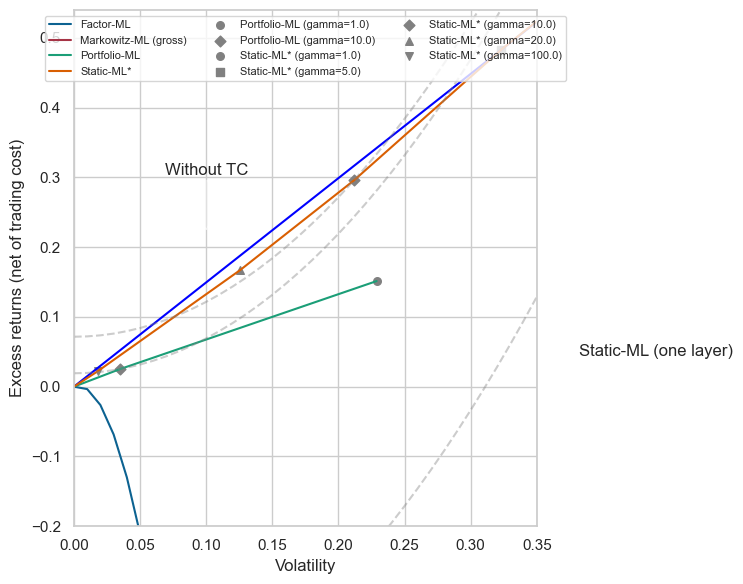

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forudsætninger:
# - ef_all_ss er en DataFrame med kolonnerne: ["type", "wealth_end", "gamma_rel", "inv", "to", "r",
#   "sd", "sr_gross", "tc", "r_tc", "sr", "obj", "vol_target", "n", "fi", ... evt. "eom_ret" m.v.]
# - pf_set er et dictionary, fx:
pf_set = {"wealth": 1e10, "gamma_rel": 10}
# - main_types er en liste over de vigtigste typer (f.eks.)
main_types = ["Portfolio-ML", "Static-ML*", "Static-ML", "Factor-ML"]

# 1. Sørg for, at "type" er en kategorisk variabel med en specifik rækkefølge.
new_order = main_types + ["Markowitz-ML (gross)"]
ef_all_ss["type"] = pd.Categorical(ef_all_ss["type"], categories=new_order, ordered=True)

# 2. Byg df_plot ved at filtrere ud fra ef_all_ss:
#    Vi fjerner rækker med type "Static-ML" og beholder kun de med wealth_end = pf_set["wealth"].
df_plot = ef_all_ss[(ef_all_ss["type"] != "Static-ML") & (ef_all_ss["wealth_end"] == pf_set["wealth"])].copy()

# 3. Tilføj de "dummy"-rækker
# Vi ønsker at tilføje alle kolonner (så dummy-rækkerne har samme kolonne-opsætning),
# men med "r_tc" og "sd" sat til 0.
columns_all = ef_all_ss.columns.tolist()

# Dummy for type "Portfolio-ML" og "Static-ML*":
dummy1 = pd.DataFrame({
    "type": ["Portfolio-ML", "Static-ML*"],
    "r_tc": [0, 0],
    "sd": [0, 0]
})
# Fyld de øvrige kolonner med NaN:
for col in columns_all:
    if col not in dummy1.columns:
        dummy1[col] = np.nan

# Dummy for type "Markowitz-ML (gross)":
dummy2 = pd.DataFrame({
    "type": ["Markowitz-ML (gross)"]
})
for col in columns_all:
    if col not in dummy2.columns:
        dummy2[col] = np.nan

# Kombinér df_plot med dummy1 og dummy2:
df_plot = pd.concat([df_plot, dummy1, dummy2], ignore_index=True, sort=False)

# 4. Nu kan vi begynde at plotte
# Plot-indstillinger
ef_y_low = -0.2
ef_xmax = 0.35
plot_txt_size = 12  # Angiver font size
tpf_col = 10       # Vi antager, at colours_theme er en dictionary med nøgler; se kommentar nedenfor
sta_1l_x = 0.265
# Sæt sta_1l_y til static_raw["r_tc"]
# (Her antages, at static_raw er en DataFrame med type "Static-ML" for de ønskede wealth og gamma_rel)
# Hvis static_raw er tom, så skal du evt. definere en standardværdi.
if not static_raw.empty:
    sta_1l_y = static_raw["r_tc"]
else:
    sta_1l_y = None

# Vi definerer et eksempel på colours_theme.
# Sørg for, at nøglen tpf_col (her 10) findes.
colours_theme = {1: "red", 5: "green", 10: "blue", 20: "orange", 100: "purple", "Markowitz-ML (gross)": "black"}
# Her bruges tpf_col som nøgleværdi i colours_theme – vi skal sikre, at tpf_col (10) er defineret i ordbogen.

fig, ax = plt.subplots(figsize=(8,6))

# Annotationer – svarende til annotate() i ggplot
ax.text(0.1, 0.31, "Without TC", fontsize=plot_txt_size, ha="center", va="center")
ax.annotate("", xy=(0.12, 0.2), xytext=(0.1, 0.3),
            arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))
ax.annotate("", xy=(0.1, 0.22), xytext=(0.1, 0.3),
            arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))

# Tegn en "abline" med intercept 0 og hældning tpf_slope
# tpf_slope er allerede defineret (fx som numerisk værdi)
ax.axline((0, 0), slope=tpf_slope, color=colours_theme.get(tpf_col, "black"), alpha=1)

# Tegn linjer for hver type
# Vi grupperer df_plot efter "type" og sorterer efter "sd"
for typ, grp in df_plot.groupby("type"):
    grp_sorted = grp.sort_values("sd")
    ax.plot(grp_sorted["sd"], grp_sorted["r_tc"], label=typ, marker=None)

# Tegn punkter – her bruger vi farve efter type og marker (shape) efter gamma_rel.
# Definér en mapping for marker ud fra gamma_rel:
markers = {1: "o", 5: "s", 10: "D", 20: "^", 100: "v"}
default_marker = "o"
for typ, grp in df_plot.groupby("type"):
    for gamma_val, subgrp in grp.groupby("gamma_rel"):
        mkr = markers.get(gamma_val, default_marker)
        ax.scatter(subgrp["sd"], subgrp["r_tc"], 
                   color=colours_theme.get(typ, "gray"),
                   marker=mkr, s=30,
                   label=f"{typ} (gamma={gamma_val})")

# Tegn en punkteret linje for mv_ss, hvor r_tc <= 0.7
if "r_tc" in mv_ss.columns and "sd" in mv_ss.columns:
    mv_subset = mv_ss[mv_ss["r_tc"] <= 0.7].sort_values("sd")
    ax.plot(mv_subset["sd"], mv_subset["r_tc"], linestyle="dotted",
            color=colours_theme.get(tpf_col, "black"))

# Annotation for static_raw: Hvis static_raw ikke er tom, tegn en firkant og tilføj tekst og en pil.
if not static_raw.empty:
    for idx, row in static_raw.iterrows():
        ax.scatter(row["sd"], row["r_tc"], marker="s", s=30, color=colours_theme.get("Static-ML", "black"))
        ax.text(row["sd"], 0.05, "Static-ML (one layer)", fontsize=plot_txt_size,
                ha="center", va="center")
        ax.annotate("", xy=(row["sd"], row["r_tc"] - 0.02), xytext=(row["sd"], 0.07),
                    arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))

# Akselabels
ax.set_xlabel("Volatility")
ax.set_ylabel("Excess returns (net of trading cost)")

ax.set_xlim(0, ef_xmax)
ax.set_ylim(ef_y_low, 0.54)

# Legend – vi laver en samlet legend
ax.legend(fontsize=8, loc="upper center", ncol=3)

# 5. Tilføj indifferenskurver
# For hver unik u_target (fra points["obj"]) tilføjes en dashed linje.
# Forudsæt: indifference_curves har kolonnerne "u", "sd", "r_tc"
for u_tgt in points["obj"].unique():
    ic_data = indifference_curves[indifference_curves["u"] == u_tgt].sort_values("sd")
    if not ic_data.empty:
        ax.plot(ic_data["sd"], ic_data["r_tc"], linestyle="dashed", alpha=0.40, color="gray")

plt.tight_layout()
plt.show()


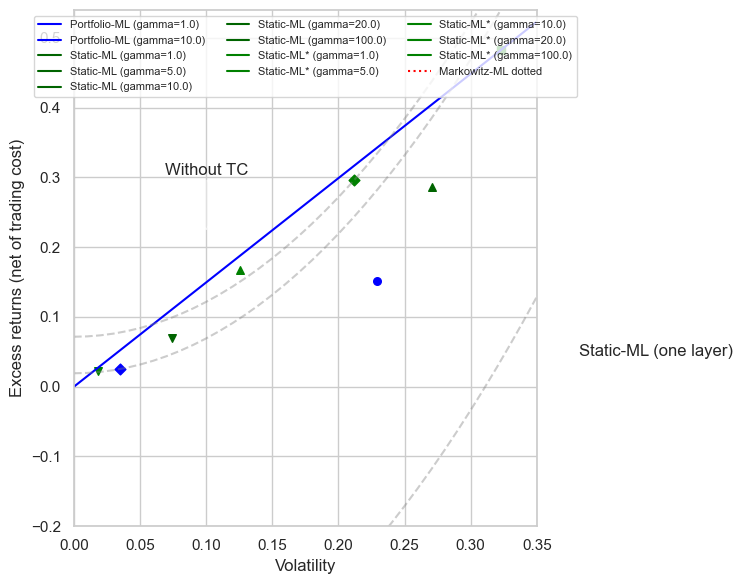

In [266]:
pf_set = {"wealth": 1e10, "gamma_rel": 10}

# Du har en liste over dine hovedtyper
main_types = ["Portfolio-ML", "Static-ML*", "Static-ML", "Factor-ML", "Markowitz-ML", "Markowitz-ML (gross)"]

# Gør "type" til en kategorisk variabel med ønsket rækkefølge (for legend)
ef_all_ss["type"] = pd.Categorical(ef_all_ss["type"], categories=main_types, ordered=True)

# 1) Filtrer data på wealth_end = pf_set["wealth"], men UNDLAD at udelukke “Static-ML”
#    Hvis du vil have alt med (også Markowitz-linjer, Factor-ML, osv.), kan du blot:
df_plot = ef_all_ss[ef_all_ss["wealth_end"] == pf_set["wealth"]].copy()

# 2) Tilføj dummy-rækker for at sikre, at ALLE typer vises i legend
all_columns = df_plot.columns
dummy_rows = []
for t in main_types:
    row_dict = {col: np.nan for col in all_columns}
    row_dict["type"] = t
    row_dict["r_tc"] = 0
    row_dict["sd"] = 0
    dummy_rows.append(row_dict)
dummy_df = pd.DataFrame(dummy_rows)

df_plot = pd.concat([df_plot, dummy_df], ignore_index=True, sort=False)

# 3) Du har vist definéret en Sharpe-linje "tpf_slope" (en hældning),
#    samt "mv_ss" med en Markowitz-linje (evt. punkteret).
#    Du har formentlig også data "points" og "indifference_curves".
#    Nedenfor antager vi, at disse DataFrames / variable er defineret og tilgængelige.

# Eksempel:
# tpf_slope = 1.494820106448777
# mv_ss = ...
# points = ...
# indifference_curves = ...
# static_raw = ...

# 4) Plotindstillinger
ef_y_low = -0.2
ef_xmax = 0.35
plot_txt_size = 12
tpf_col = 10  # Hvis du har et farveopslag
colours_theme = {
    "Portfolio-ML": "blue",
    "Static-ML*": "green",
    "Static-ML": "darkgreen",
    "Factor-ML": "orange",
    "Markowitz-ML": "red",
    "Markowitz-ML (gross)": "gray",
    10: "blue",    # Til tpf_col
}
# Obs: Juster eventuelt disse farver, så de passer med dine R-farver

fig, ax = plt.subplots(figsize=(8,6))

# 5) Annotationer
ax.text(0.1, 0.31, "Without TC", fontsize=plot_txt_size, ha="center", va="center")
ax.annotate("", xy=(0.12, 0.2), xytext=(0.1, 0.3),
            arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))
ax.annotate("", xy=(0.1, 0.22), xytext=(0.1, 0.3),
            arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))

# 6) Tegn "abline" for tpf_slope
ax.axline((0, 0), slope=tpf_slope, color=colours_theme.get(tpf_col, "black"), alpha=1)

# 7) Tegn en kurve (linjer) for hver type.
#    Der kan være flere rækker for en type (fx forskellige gamma_rel).
#    Hvis du vil have separate linjer for hver gamma_rel, group på ["type", "gamma_rel"].
#    Hvis du vil have en linje for hver type over tid, sortér på "sd" og "gamma_rel".
for (typ, gamm), grp in df_plot.groupby(["type", "gamma_rel"]):
    grp_sorted = grp.sort_values("sd")
    color = colours_theme.get(typ, "black")
    label_txt = f"{typ}"
    if not pd.isna(gamm):
        label_txt += f" (gamma={gamm})"
    # Tegn linje
    ax.plot(grp_sorted["sd"], grp_sorted["r_tc"], marker=None, label=label_txt, color=color)

# 8) Tegn punkter
#    Hvis du ønsker punkter i stedet for (eller ud over) linjer.
#    Her bruger vi en shape/marker baseret på gamma_val (lige som før).
markers = {1: "o", 5: "s", 10: "D", 20: "^", 100: "v"}
default_marker = "o"
for (typ, gamm), grp in df_plot.groupby(["type", "gamma_rel"]):
    color = colours_theme.get(typ, "black")
    marker = markers.get(gamm, default_marker)
    label_txt = f"{typ}"
    if not pd.isna(gamm):
        label_txt += f" (gamma={gamm})"
    ax.scatter(grp["sd"], grp["r_tc"], color=color, marker=marker, s=30, label=label_txt)

# 9) Tegn en punkteret linje fra mv_ss, hvis den findes
if "r_tc" in mv_ss and "sd" in mv_ss:
    mv_subset = mv_ss[mv_ss["r_tc"] <= 0.7].sort_values("sd")
    ax.plot(mv_subset["sd"], mv_subset["r_tc"], linestyle="dotted",
            color=colours_theme.get("Markowitz-ML", "red"), label="Markowitz-ML dotted")

# 10) Tegn "Static-ML (one layer)" annotationer fra static_raw
if not static_raw.empty:
    for idx, row in static_raw.iterrows():
        ax.scatter(row["sd"], row["r_tc"], marker="s", s=30, color=colours_theme.get("Static-ML", "darkgreen"))
        ax.text(row["sd"], 0.05, "Static-ML (one layer)", fontsize=plot_txt_size, ha="center", va="center")
        ax.annotate("", xy=(row["sd"], row["r_tc"] - 0.02), xytext=(row["sd"], 0.07),
                    arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.75))

# 11) Tilføj indifferenskurver
for u_tgt in points["obj"].unique():
    ic_data = indifference_curves[indifference_curves["u"] == u_tgt].sort_values("sd")
    if not ic_data.empty:
        ax.plot(ic_data["sd"], ic_data["r_tc"], linestyle="dashed", alpha=0.4, color="gray")

# 12) Akseskalaer, legend og layout
ax.set_xlim(0, ef_xmax)
ax.set_ylim(ef_y_low, 0.54)
ax.set_xlabel("Volatility")
ax.set_ylabel("Excess returns (net of trading cost)")

# For at undgå duplikerede legend-items (pga. linjer + scatter med samme label)
handles, labels = ax.get_legend_handles_labels()
# Zip dem sammen for at fjerne duplikater i rækkefølge
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
ax.legend(unique.values(), unique.keys(), fontsize=8, loc="upper center", ncol=3)

plt.tight_layout()
plt.show()

In [267]:
missing_type = ef_all_ss[ef_all_ss["type"].isna()]
print("Rækker med manglende type:")
print(missing_type)


Rækker med manglende type:
    type    wealth_end  gamma_rel        inv         to         r    sd  \
63   NaN  1.000000e+10       10.0   0.000000   0.000000  0.000000  0.00   
64   NaN  1.000000e+10       10.0   0.255680   0.258895  0.014948  0.01   
65   NaN  1.000000e+10       10.0   0.511360   0.517790  0.029896  0.02   
66   NaN  1.000000e+10       10.0   0.767040   0.776685  0.044845  0.03   
67   NaN  1.000000e+10       10.0   1.022720   1.035579  0.059793  0.04   
68   NaN  1.000000e+10       10.0   1.278400   1.294474  0.074741  0.05   
69   NaN  1.000000e+10       10.0   1.534080   1.553369  0.089689  0.06   
70   NaN  1.000000e+10       10.0   1.789760   1.812264  0.104637  0.07   
71   NaN  1.000000e+10       10.0   2.045441   2.071159  0.119586  0.08   
72   NaN  1.000000e+10       10.0   2.301121   2.330054  0.134534  0.09   
73   NaN  1.000000e+10       10.0   2.556801   2.588949  0.149482  0.10   
74   NaN  1.000000e+10       10.0   2.812481   2.847843  0.164430  0.11  

# Figure 1.B

In [248]:
df_expand = pd.DataFrame({
    'wealth_end': [settings['ef']['wealth']],  # fx 1
    'sd': [0],
    'r_tc': [0]
})

# Rbind ef_ss og expand.grid-delen.
# Vi antager, at ef_ss allerede indeholder kolonnerne 'type', 'wealth_end', 'sd', 'r_tc'
comb_data = pd.concat([ef_ss, df_expand], ignore_index=True, sort=False)

# Sæt type for de rækker, der kom fra expand.grid – vi antager, at de kan identificeres ved at sd==0, r_tc==0, og wealth_end==settings['ef']['wealth']
mask_expand = (comb_data['sd'] == 0) & (comb_data['r_tc'] == 0) & (comb_data['wealth_end'] == settings['ef']['wealth'])
comb_data.loc[mask_expand, 'type'] = "tpf"

# Herefter, if_else(wealth_end==1, 1, wealth_end)
comb_data['wealth_end'] = comb_data['wealth_end'].apply(lambda x: 1 if x == 1 else x)

# Rbind med mv_ss, hvor vi sætter wealth_end = 1 og type = "mv"
mv_ss_mod = mv_ss.copy()
mv_ss_mod['wealth_end'] = 1
mv_ss_mod['type'] = "mv"
comb_data = pd.concat([comb_data, mv_ss_mod], ignore_index=True, sort=False)

# Mutér gamma_rel: konverter til en kategorisk med niveauer fra settings['ef']['gamma_rel']
comb_data['gamma_rel'] = pd.Categorical(comb_data['gamma_rel'], categories=settings['ef']['gamma_rel'], ordered=True)

# Filtrer for de wealth_end-værdier, vi ønsker: 1, 1e9, 1e10, 1e11
comb_data = comb_data[comb_data['wealth_end'].isin([1, 1e9, 1e10, 1e11])]

# 2. Byg inputs til indifference curves
# Vælg de rækker, hvor type er Portfolio-ML, Static-ML*, eller Static-ML,
# og wealth_end, gamma_rel svarer til pf_set
mask_points = (
    ((comb_data['type'].isin(["Portfolio-ML", "Static-ML*", "Static-ML"])) &
     (comb_data['wealth_end'] == pf_set['wealth']) &
     (comb_data['gamma_rel'] == pf_set['gamma_rel']))
    # Hvis du også vil inkludere Factor-ML med vol_target == 0.01, kan du udvide masken.
)
points = comb_data.loc[mask_points].copy()

# Herefter defineres indifference_curves.
# For hver række i points (hver portefølje), udtrækkes u_target = obj og beregnes
# for en række volatilitetsværdier v en DataFrame med r_tc = u_target + pf_set['gamma_rel']/2 * v^2
indifference_curves_list = []
for idx, row in points.iterrows():
    u_target = row['obj']
    # Du kan definere et vol_space, fx en simpel sekvens:
    vol_space = np.arange(0, 0.4 + 0.01, 0.01)
    df_ic = pd.DataFrame({
        'sd': vol_space,
        'r_tc': u_target + pf_set['gamma_rel'] / 2 * (vol_space**2)
    })
    df_ic['u'] = u_target
    indifference_curves_list.append(df_ic)
indifference_curves = pd.concat(indifference_curves_list, ignore_index=True)

# 3. Plot Figure 1A
# Vi antager, at tpf_slope er en konstant (vi sætter den som fx den anden værdi af sr_gross for Markowitz-ML)
tpf_data = comb_data[comb_data['type'] == "Markowitz-ML"]
# Undgå første række, hvis den indeholder NaN
tpf_slope = tpf_data['sr_gross'].dropna().iloc[1] if len(tpf_data['sr_gross'].dropna())>1 else tpf_data['sr_gross'].dropna().iloc[0]

static_raw = comb_data[(comb_data['type'].isin(["Static-ML"])) & 
                        (comb_data['wealth_end'] == pf_set['wealth']) & 
                        (comb_data['gamma_rel'] == pf_set['gamma_rel'])]

# Plotindstillinger
ef_y_low = -0.2
ef_xmax = 0.35
plot_txt_size = 10  # juster efter behov
sta_1l_x = 0.265
sta_1l_y = static_raw['r_tc'].mean()  # eksempel, tilpas hvis nødvendigt

# Opdater type-kolonnen: sørg for, at den er kategorisk med de ønskede niveauer
main_types = ["Portfolio-ML", "Static-ML*", "Markowitz-ML"]
comb_data['type'] = pd.Categorical(comb_data['type'], categories=main_types + ["Markowitz-ML (gross)"], ordered=True)

# Byg plottet med seaborn og matplotlib
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Tilføj en tekstannotering for "Without TC"
ax.text(0.1, 0.31, "Without TC", fontsize=plot_txt_size, ha="center")

# Tilføj en pil (eksempel)
ax.annotate("", xy=(0.12, 0.2), xytext=(0.1, 0.3),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.75))

# Plot tpf-linjen (for type=="tpf")
tpf_plot = comb_data[comb_data['type'] == "tpf"]
sns.lineplot(data=tpf_plot, x="sd", y="r_tc", hue="type", ax=ax, legend=False)

# Plot tpf-punkter med form baseret på gamma_rel
sns.scatterplot(data=tpf_plot, x="sd", y="r_tc", hue="type", style="gamma_rel", ax=ax, s=50, legend=False)

# Plot mv-data (dotted path)
mv_plot = comb_data[comb_data['type'] == "mv"]
ax.plot(mv_plot["sd"], mv_plot["r_tc"], linestyle="dotted", color="black")

# Indstil akserne
ax.set_xlim(0, ef_xmax)
ax.set_ylim(ef_y_low, 0.54)
ax.set_xlabel("Volatility")
ax.set_ylabel("Excess returns (net of trading cost)")

# Plot static_raw punkter (eksempel med rektangel-form)
sns.scatterplot(data=static_raw, x="sd", y="r_tc", ax=ax, marker="s", s=50, color="black")
ax.text(static_raw["sd"].mean(), 0.05, "Static-ML (one layer)", fontsize=plot_txt_size, ha="center", va="center")
ax.annotate("", xy=(static_raw["sd"].mean(), static_raw["r_tc"].mean()-0.02),
            xytext=(static_raw["sd"].mean(), 0.07),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.75))

# Tilføj indifference curves (plot som dashed linjer)
for u_target in indifference_curves['u'].unique():
    df_curve = indifference_curves[indifference_curves['u'] == u_target]
    ax.plot(df_curve["sd"], df_curve["r_tc"], linestyle="dashed", alpha=0.40, color="gray")

plt.tight_layout()
plt.show()

# 4. Figure 1B – Kombiner data til et samlet plot (comb_data)
# I R koden kombineres ef_ss, mv_ss, tpf_ss mm. Her antages det, at ef_ss og mv_ss er tilgængelige.
# Eksempel:
comb_data2 = pd.concat([
    ef_ss[ef_ss['type'].isin(["Portfolio-ML", "Static-ML*", "Static-ML"])],
    # Hvis du har factor_ss og tpf_ss:
    factor_ss.assign(gamma_rel=np.nan, type="Factor-ML", wealth_end=pf_set['wealth']),
    tpf_ss.assign(gamma_rel=np.nan, type="Markowitz-ML", wealth_end=pf_set['wealth'])
], ignore_index=True, sort=False)

# Eventuelt tilføj en række fra expand.grid som i R
expand_df = pd.DataFrame({'wealth_end': [settings['ef']['wealth']], 'sd': [0], 'r_tc': [0]})
comb_data2 = pd.concat([comb_data2, expand_df], ignore_index=True, sort=False)

# Juster wealth_end: hvis wealth_end == 1, behold 1, ellers (fx) lad den være uændret
comb_data2['wealth_end'] = comb_data2['wealth_end'].apply(lambda x: 1 if x==1 else x)

# Plot kombinerede data (eksempel med seaborn)
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
sns.lineplot(data=comb_data2[comb_data2['type'] == "tpf"], x="sd", y="r_tc", hue="wealth_end", ax=ax2, legend="brief")
sns.scatterplot(data=comb_data2[comb_data2['type'] == "tpf"], x="sd", y="r_tc", hue="wealth_end", style="gamma_rel", ax=ax2, s=50, legend=False)
sns.lineplot(data=comb_data2[comb_data2['type'] == "mv"], x="sd", y="r_tc", ax=ax2, linestyle="dotted", color="black")
ax2.set_xlim(0, ef_xmax)
ax2.set_ylim(0, 0.75)
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Excess returns (net of trading cost)")
plt.legend(title="Wealth by 2020:", loc="upper right")
plt.tight_layout()
plt.show()

ValueError: ('Lengths must match to compare', (3,), (4,))